In [1]:
import json
import numpy as np
import random

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [2]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

n_examples = 100

tb = 60
tf = 60

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

#train_targs = (np.random.rand(n_examples,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])

# random buttons and food
if False:
    train_thetas = [random.random()*2*np.pi for i in range(n_examples)]
    train_thetas_targ = [random.random()*2*np.pi for i in range(n_examples)]

# equally-spaced buttons and random food
if True:
    train_thetas = np.linspace(0,2*np.pi,n_examples,endpoint=False)
    train_thetas_targ = [random.random()*2*np.pi for i in range(n_examples)]

#train_thetas = [random.random()*2*np.pi for i in range(n_examples)]
#train_thetas = np.linspace(0,2*np.pi,n_examples,endpoint=False)

#train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
#train_bttns = (np.random.rand(20,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
train_targs = train_bttns + np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas_targ])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])
#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]

#### Low network

In [3]:
N, I, O, T = 500, 80, 2, tb+tf
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt

beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 50.
sigma_targ = 0. #10**1.5
sigma_in = 20. #12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = n_examples

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

"""
par_low = par
par_high = par

par_low['sigma_context'] = 50
par_high['sigma_context'] = 0
par_high['sigma_Jrec'] = 0
par_low['sigma_targ'] = 0
par_high['sigma_targ'] = 30
"""

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000
nIterRec = 200

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb_low = LTTB (par)
#lttb_high = LTTB (par_high)

In [4]:
# define clock and target

lttb_low.y_targ_collection = []
lttb_low.I_clock_collection = []

#lttb_high.y_targ_collection = []
#lttb_high.I_clock_collection = []

for k in range(n_examples):
    
    lttb_low.y_targ_collection.append( train_exp[k][1] )
    lttb_low.I_clock_collection.append( train_exp[k][0] )
    
    #lttb_high.y_targ_collection.append( np.array([[1. if t<tb else 0. for t in range(tb+tf)],[0. if t<tb else 1. for t in range(tb+tf)]]) )
    #lttb_high.I_clock_collection.append( train_exp[k][0] ) # same as low network
    
    
    #lttb.y_targ_collection.append( train_exp[k][1].T[0:tb].T )
    #lttb.I_clock_collection.append( train_exp[k][0].T[0:tb].T )

In [5]:
lttb_low.j_cont[0:int(Ne/2),1] = 0
lttb_low.j_cont[int(Ne/2):,0] = 0
lttb_low.j_cont[Ne:,:] = 0

In [6]:
if False:
    plt.imshow(np.array(lttb_low.I_clock_collection[5]))

In [7]:
## Training Rec
par['T'] = tb+tf
#par_high['T'] = par['T']
lttb_low.T = tb+tf
#lttb_high.T = tb+tf

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

eta_low = 0.
eta_out_low = 0.03
etaW = 0.

#eta_high = 2.
#eta_out_high = 0.03

##############################

SR_low_list = []
#SR_high_list = []

for cont_index in range(n_examples):
    
    lttb_low.initialize(par)
    lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
    lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
    
    #lttb_high.initialize(par_high)
    #lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
    #lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
    
    for t in range(lttb_low.T-2):
        
        if(t<tb):
            lttb_low.cont = np.array([1,0])
        else:
            lttb_low.cont = np.array([0,1])
        
        #lttb_low.cont = lttb_high.y_targ.T[t]
        #lttb_high.cont = np.array([0,0])
        
        lttb_low.step(apicalFactor = apicalFactorTrain)
        #lttb_high.step(apicalFactor = apicalFactorTrain)
        
        SR_low = lttb_low.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
        #SR_high = lttb_high.B_filt_rec[:,t+1] # lttb.S_filtRO[:,t+1]
        
    SR_low_list.append(lttb_low.B_filt)
    #SR_high_list.append(lttb_high.B_filt_rec)

print('...done.')

...done.


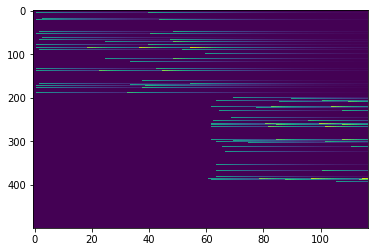

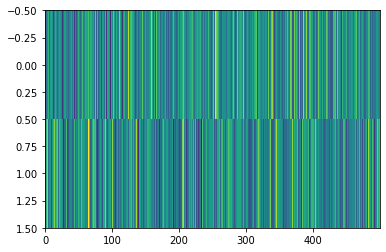

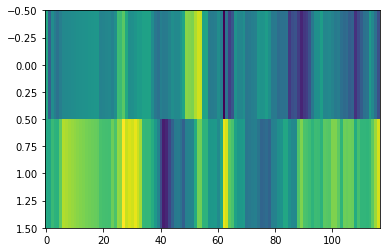

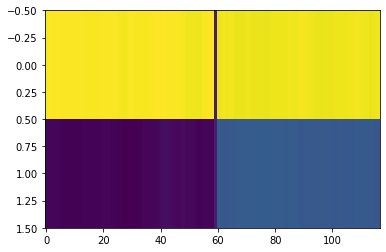

In [8]:
if True:
    plt.imshow(lttb_low.B_filt[:,1:-2], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_low.Jout[:,:], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_low.Jout[:,:]@lttb_low.B_filt[:,1:-2], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_low.y_targ[:,1:-2] - (lttb_low.Jout[:,:]@lttb_low.B_filt[:,1:-2]), aspect='auto')
    plt.show()
    
    #np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
    
    #plt.imshow(lttb_high.B_filt_rec[:,:], aspect='auto')
    #plt.show()

In [9]:
#####################################

test_every = 5

ERRORS_low = np.zeros((int(nIterRec/test_every),n_examples))
#ERRORS_high = np.zeros((int(nIterRec/test_every),n_examples))

learning_OnLine = False

for iteration in range(nIterRec):

    if iteration<nIterRec-1:
        print('t=%d/%d' % (iteration+1,nIterRec), end='\r')
    else:
        print('t=%d/%d' % (iteration+1,nIterRec), end='\n')
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_examples):
        
        lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
        #lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
        
        #ON-LINE
        
        if learning_OnLine:
            
            lttb_low.initialize(par)
            #lttb_high.initialize(par_high)
            
            lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
            #lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
            
            #run simulation
            dH = 0
            
            for t in range(lttb_low.T-2):
                
                if(t<tb):
                    lttb_low.cont = np.array([1,0])
                else:
                    lttb_low.cont = np.array([0,1])
                
                #lttb_low.cont = lttb_high.y_targ.T[t]
                #lttb_high.cont = np.array([0,0])
                
                lttb_low.step(apicalFactor = apicalFactorTrain)
                #lttb_high.step(apicalFactor = apicalFactorTrain)
                
                #dH = dH*(1-dt/tau_m) + dt/tau_m*lttb_high.S_filt[:,t]
                #DJ = np.outer(( lttb_high.S_apic_dist[:,t+1] - f(lttb_high.VapicRec[:,t],gamma) )*(1-lttb_high.S_apic_dist[:,t]) ,dH)
                #lttb_high.J =  lttb_high.J + eta_high*DJ
                
                SR_low = lttb_low.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
                Y_low = lttb_low.Jout@SR_low
                DJRO = np.outer(lttb_low.y_targ[:,t+1] - Y_low,SR_low.T)
                lttb_low.Jout = lttb_low.Jout + eta_out_low*DJRO
                
                #if t==0 and cont_index==0:
                    #print(lttb_low.Jout[0,0])
                
                #SR_high = lttb_high.B_filt_rec[:,t] # lttb.S_filtRO[:,t+1]
                #Y_high = lttb_high.Jout@SR_high
                #DJRO = np.outer(lttb_high.y_targ[:,t+1] - Y_high,SR_high.T)
                #lttb_high.Jout =  lttb_high.Jout + eta_out_high*DJRO
                
        if not learning_OnLine:
            
            #OFF-LINE
            
            SR_low = SR_low_list[cont_index]
            Y_low = lttb_low.Jout@SR_low
            DJRO = (lttb_low.y_targ[:,1:-1] - Y_low[:,0:-2]) @ ( SR_low.T[0:-2])
            lttb_low.Jout =  lttb_low.Jout + eta_out_low*DJRO
       
        
    ###### Test
    
    if (iteration+1)%test_every==0:
        
        for cont_index in range(n_examples):
            
            lttb_low.initialize(par)
            lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
            lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
            
            #lttb_high.initialize(par_high)
            #lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
            #lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]

            #run simulation

            for t in range(lttb_low.T-2):
                
                if(t<tb):
                    lttb_low.cont = np.array([1,0])
                else:
                    lttb_low.cont = np.array([0,1])
                
                #lttb_low.cont = lttb_high.y_targ.T[t]
                #lttb_high.cont = np.array([0,0])
                
                lttb_low.step(apicalFactor = apicalFactorTest)
                #lttb_high.step(apicalFactor = apicalFactorTest)

            SR_low = lttb_low.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
            #plt.imshow(lttb_low.B_filt[:,1:-2], aspect='auto')
            #plt.show()
            #plt.imshow(SR_low, aspect='auto')
            #plt.show()
            Y_low = lttb_low.Jout@SR_low
            #plt.imshow(Y_low, aspect='auto')
            #plt.show()
            #plt.imshow(lttb_low.y_targ[:,1:-2] - Y_low, aspect='auto')
            #plt.show()
            mse_ro_train_low = np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
            
            #if cont_index==0:
                #print('lttb_low.Jout',lttb_low.Jout[0,0])
                #print('SR_low',SR_low[0:20,0:20])
            
            #SR_high = lttb_high.B_filt_rec[:,1:-2] # lttb.S_filtRO[:,1:-2]
            #Y_high = lttb_high.Jout@SR_high
            #mse_ro_train_high = np.std(lttb_high.y_targ[:,1:-2] - Y_high)**2
            
            ERRORS_low[int(iteration/test_every),cont_index] = mse_ro_train_low
            #ERRORS_high[int(iteration/test_every),cont_index] = mse_ro_train_high

print('...done.')

t=200/200
...done.


In [10]:
if False:
    
    plt.plot(dH)
    plt.show()
    
    plt.imshow(lttb_high.S_filt, aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.S_apic_dist, aspect='auto')
    plt.show()
    
    plt.imshow(f(lttb_high.VapicRec,gamma), aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.S_apic_dist - f(lttb_high.VapicRec,gamma), aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.J)
    plt.show()
    
    plt.imshow(DJ)
    plt.show()

In [11]:
if False:
    
    plt.hist(DJ.flatten())
    plt.show()
    
    plt.hist(lttb_high.J.flatten())
    plt.show()

#### High network

In [391]:
par_high = par

par_high['sigma_context'] = 0
par_high['sigma_Jrec'] = 0
par_high['sigma_targ'] = 100

lttb_high = LTTB (par_high)

In [392]:
# define clock and target

lttb_high.y_targ_collection = []
lttb_high.I_clock_collection = []

for k in range(n_examples):
    
    lttb_high.y_targ_collection.append( np.array([[1. if t<tb else 0. for t in range(tb+tf)],[0. if t<tb else 1. for t in range(tb+tf)]]) )
    lttb_high.I_clock_collection.append( train_exp[k][0] ) # same as low network

In [393]:
lttb_high.j_cont[:,:] = 0

In [394]:
## Training Rec
par_high['T'] = tb+tf
lttb_high.T = tb+tf

apicalFactorTrain = 1
apicalFactorTest = 0

eta_high = 0.25
eta_out_high = 0.03
eta_bias_high = 0.0002
etaW = 0.

##############################

SR_high_list = []

Bias = 0

for cont_index in range(n_examples):
    
    lttb_high.initialize(par_high)
    lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
    lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
    
    for t in range(lttb_high.T-2):
        
        lttb_high.cont = np.array([0,0])
        lttb_high.step(apicalFactor = apicalFactorTrain)
        SR_high = lttb_high.B_filt_rec[:,t+1] # lttb.S_filtRO[:,t+1]
        
    SR_high_list.append(lttb_high.B_filt_rec)

print('...done.')

...done.


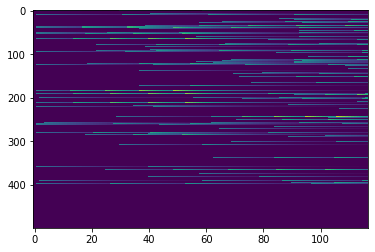

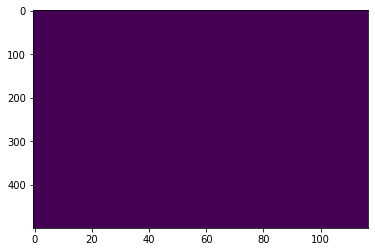

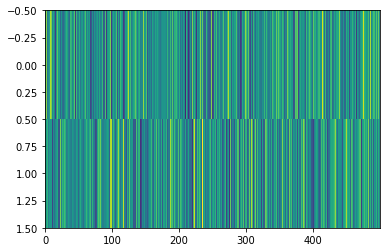

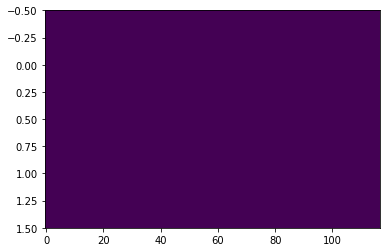

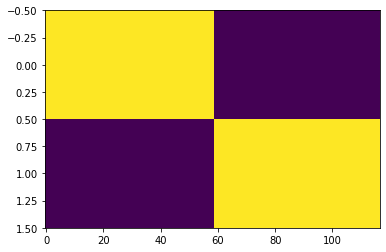

In [395]:
if True:
    plt.imshow(lttb_high.B_filt[:,1:-2], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.B_filt_rec[:,1:-2], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.Jout[:,:], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.Jout[:,:]@lttb_high.B_filt_rec[:,1:-2], aspect='auto')
    plt.show()
    
    plt.imshow(lttb_high.y_targ[:,1:-2] - (lttb_high.Jout[:,:]@lttb_high.B_filt_rec[:,1:-2]), aspect='auto')
    plt.show()
    
    #np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
    
    #plt.imshow(lttb_high.B_filt_rec[:,:], aspect='auto')
    #plt.show()

In [396]:
#####################################

nIterRec = 200
test_every = 5

ERRORS_high = np.zeros((int(nIterRec/test_every),n_examples))

learning_OnLine = True

for iteration in range(nIterRec):

    if iteration<nIterRec-1:
        print('t=%d/%d' % (iteration+1,nIterRec), end='\r')
    else:
        print('t=%d/%d' % (iteration+1,nIterRec), end='\n')
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_examples):
        
        lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
        
        #ON-LINE
        
        if learning_OnLine:
            
            lttb_high.initialize(par_high)
            lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
            
            #run simulation
            dH = 0
            
            for t in range(lttb_high.T-2):
                
                lttb_high.cont = np.array([0,0])
                
                lttb_high.step(apicalFactor = apicalFactorTrain)
                
                dH = dH*(1-dt/tau_m) + dt/tau_m*lttb_high.S_filt[:,t]
                DJ = np.outer( ( lttb_high.S_apic_dist[:,t+1] - f(lttb_high.VapicRec[:,t],gamma) )*(1-lttb_high.S_apic_prox[:,t])*lttb_high.S_wind_soma[:,t+1] ,dH)
                
                lttb_high.J =  lttb_high.J + eta_high*DJ
                
                """
                SR_high = lttb_high.B_filt_rec[:,t+1] # lttb.S_filtRO[:,t+1]
                Y_high = lttb_high.Jout@SR_high
                DJRO = np.outer(lttb_high.y_targ[:,t+1] - Y_high,SR_high.T)
                lttb_high.Jout =  lttb_high.Jout + eta_out_high*DJRO
                """
                
                SR_high = lttb_high.B_filt_rec[:,t+1] # lttb.S_filtRO[:,t+1]
                Y_high = lttb_high.Jout@SR_high + Bias
                
                DJRO = np.outer(lttb_high.y_targ[:,t+1] - Y_high,SR_high.T)
                dBias = lttb_high.y_targ[:,t+1] - Y_high
                
                lttb_high.Jout =  lttb_high.Jout + eta_out_high*DJRO
                Bias = Bias + eta_bias_high*dBias
                
        if not learning_OnLine:
            
            #OFF-LINE
            
            SR_high = SR_high_list[cont_index]
            Y_high = lttb_high.Jout@SR_high
            DJRO = (lttb_high.y_targ[:,1:-1] - Y_high[:,0:-2]) @ ( SR_high.T[0:-2])
            lttb_high.Jout = lttb_high.Jout + eta_out_high*DJRO
       
        
    ###### Test
    
    if (iteration+1)%test_every==0:
        
        for cont_index in range(n_examples):
            
            lttb_high.initialize(par_high)
            lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
            lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]

            #run simulation

            for t in range(lttb_high.T-2):
                
                lttb_high.cont = np.array([0,0])
                lttb_high.step(apicalFactor = apicalFactorTest)
            
            SR_high = lttb_high.B_filt_rec[:,1:-2] # lttb.S_filtRO[:,1:-2]
            Y_high = lttb_high.Jout@SR_high + np.tile(Bias,(117,1)).T
            mse_ro_train_high = np.std(lttb_high.y_targ[:,1:-2] - Y_high)**2
            
            ERRORS_high[int(iteration/test_every),cont_index] = mse_ro_train_high

print('...done.')

t=200/200
...done.


#### Check the training

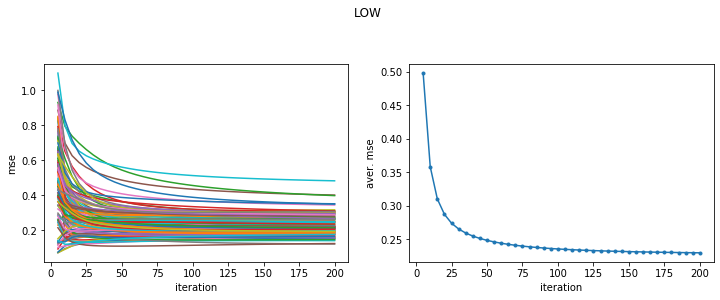

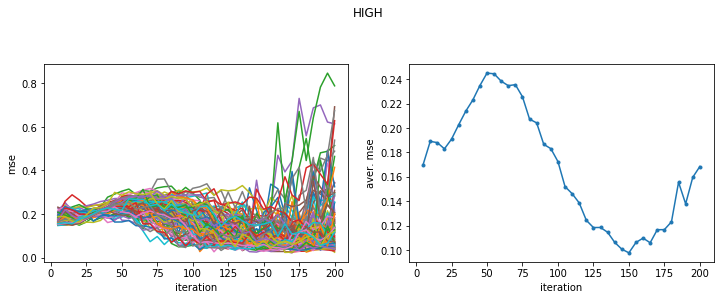

In [397]:
plt.figure(figsize=(12, 8))
plt.suptitle('LOW')

plt.subplot(221)
plt.plot(test_every*np.arange(1,1+len(ERRORS_low)),ERRORS_low)
plt.xlabel("iteration")
plt.ylabel("mse")

plt.subplot(222)
plt.plot(test_every*np.arange(1,1+len(ERRORS_low)),[np.mean(ERRORS_low[_,:]) for _ in range(len(ERRORS_low))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")

plt.show()

plt.figure(figsize=(12, 8))
plt.suptitle('HIGH')

plt.subplot(221)
plt.plot(test_every*np.arange(1,1+len(ERRORS_high)),ERRORS_high)
plt.xlabel("iteration")
plt.ylabel("mse")

plt.subplot(222)
plt.plot(test_every*np.arange(1,1+len(ERRORS_high)),[np.mean(ERRORS_high[_,:]) for _ in range(len(ERRORS_high))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")

plt.show()

In [398]:
Bias

array([0.91192979, 0.08876045])

0.2164519895232012
0.057319446188957394


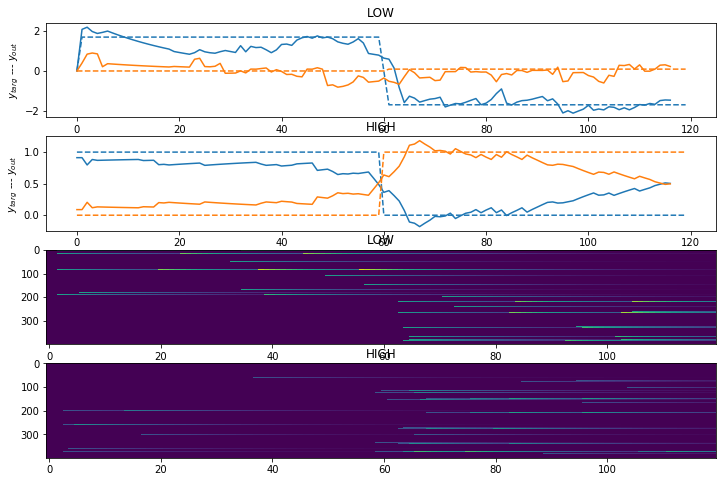

0.22184027419027633
0.11301312011136254


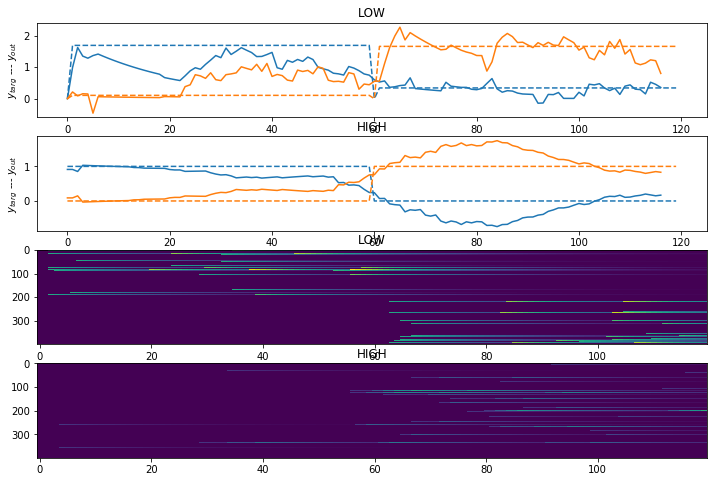

0.2992708118459444
0.06227024547768756


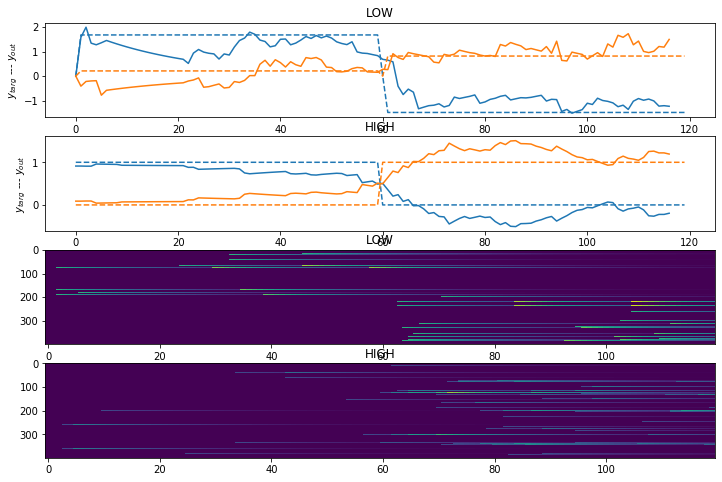

0.1737058494087017
0.19639831298820026


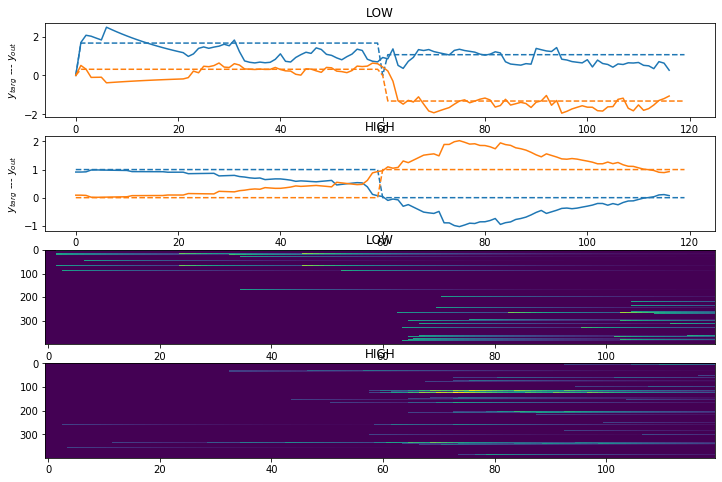

0.2084172327211427
0.6139885059803096


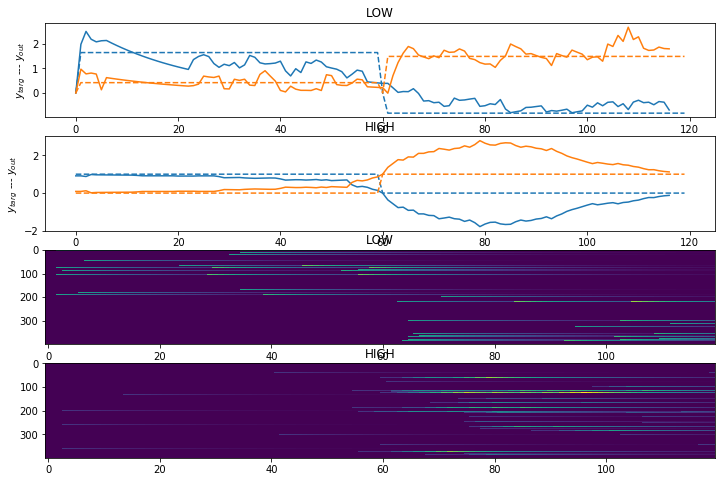

0.27387532643331136
0.6924469023130905


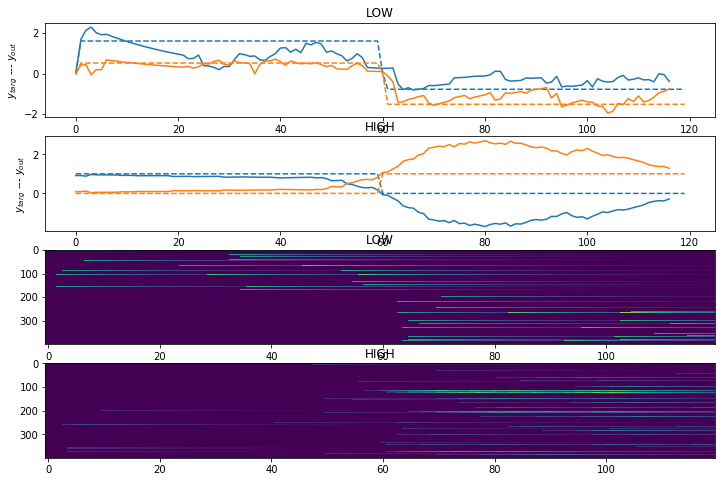

0.16060068973764113
0.3406273646684687


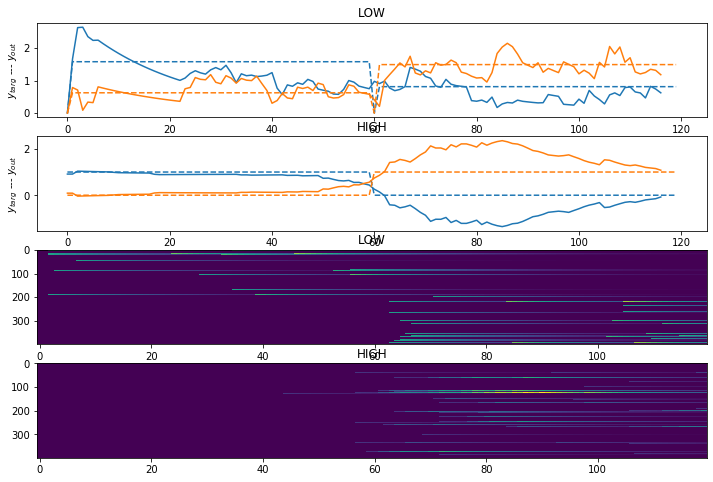

0.15120940485069903
0.10285590625741081


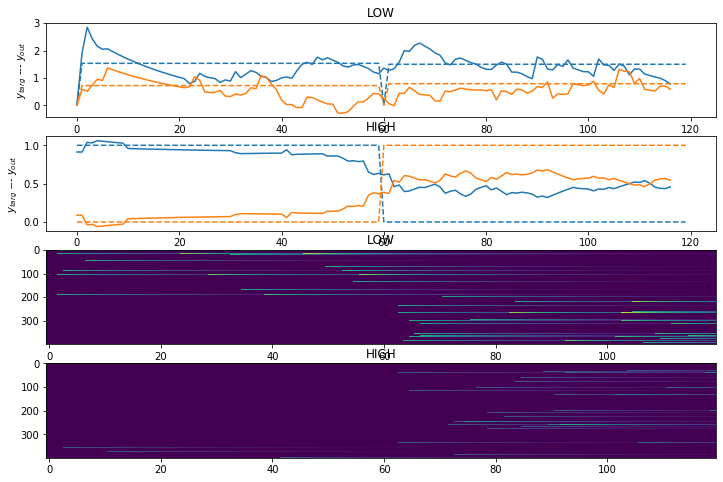

0.14156855276079724
0.05232661035017654


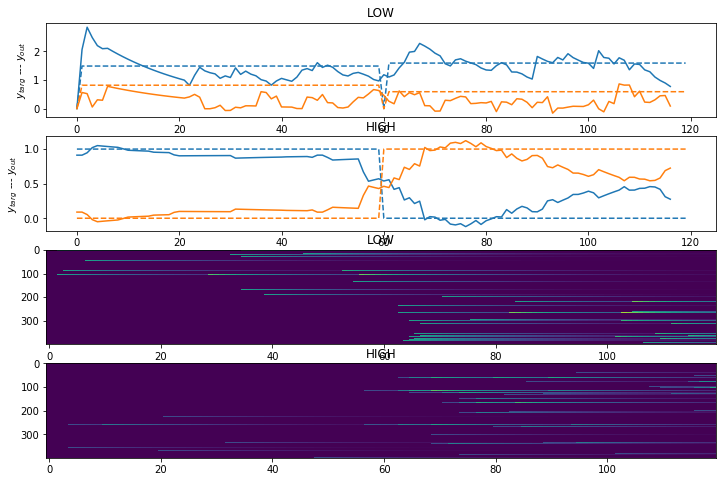

0.26085709236307114
0.043581109537047254


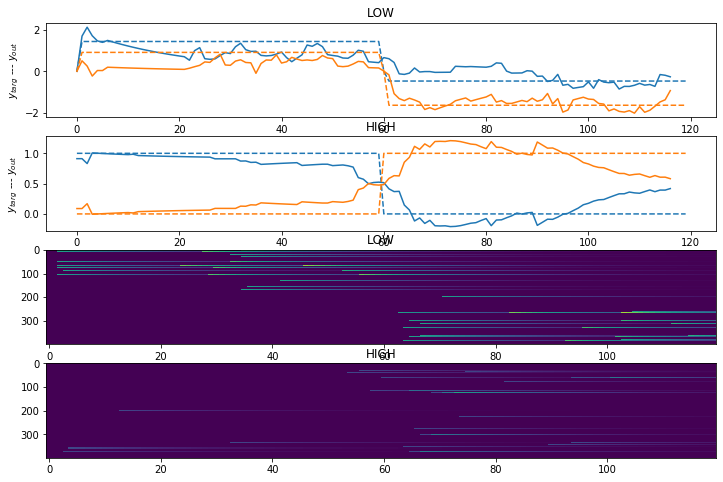

0.15295350320583767
0.12968356502946995


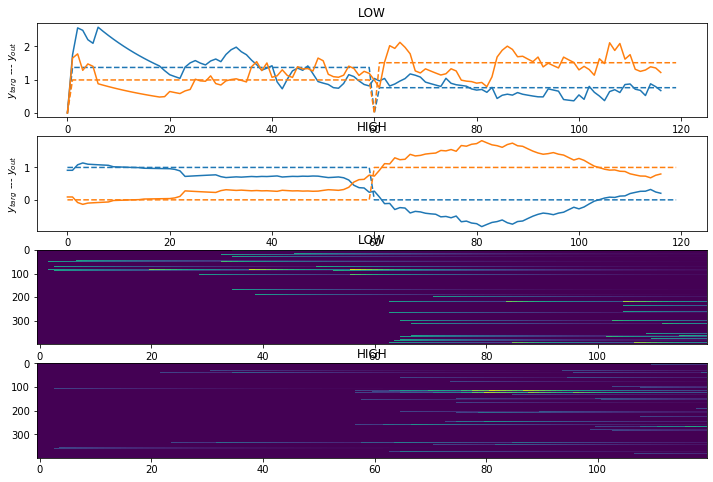

0.15780855817204253
0.07296771956386373


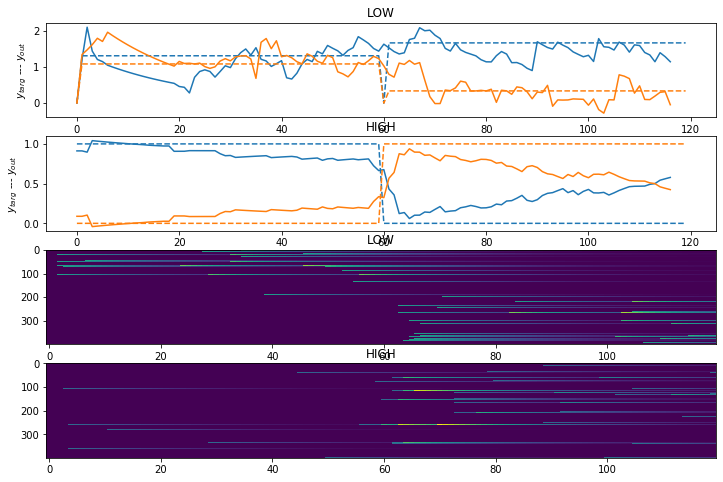

0.2929256251461872
0.29615139985913086


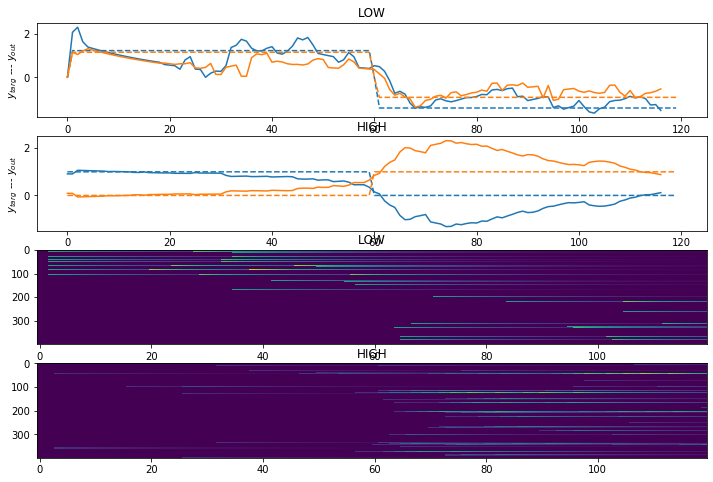

0.16862242073249747
0.13632808175685868


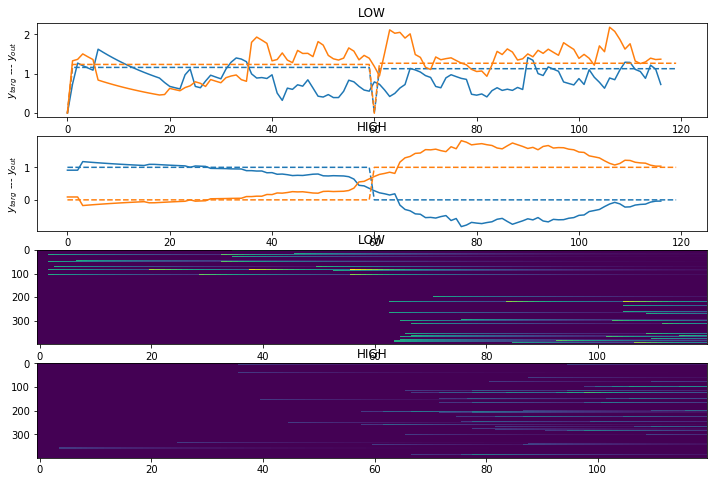

0.1856941251814391
0.21401520315335745


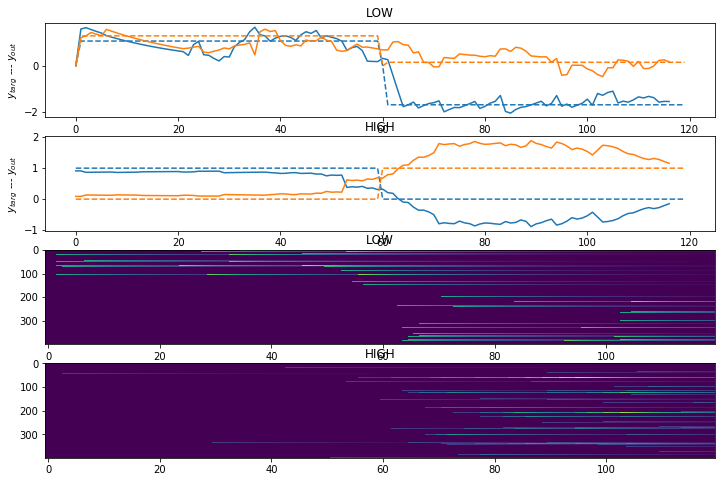

0.39913468052045775
0.03779326287305804


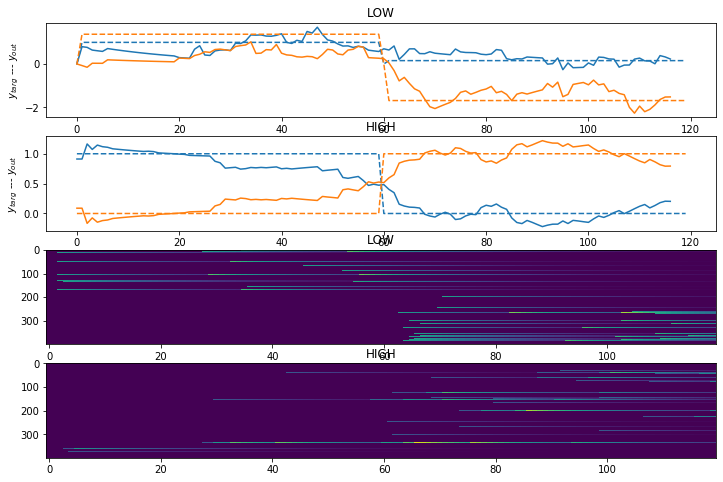

0.15690631932584456
0.04590538631092326


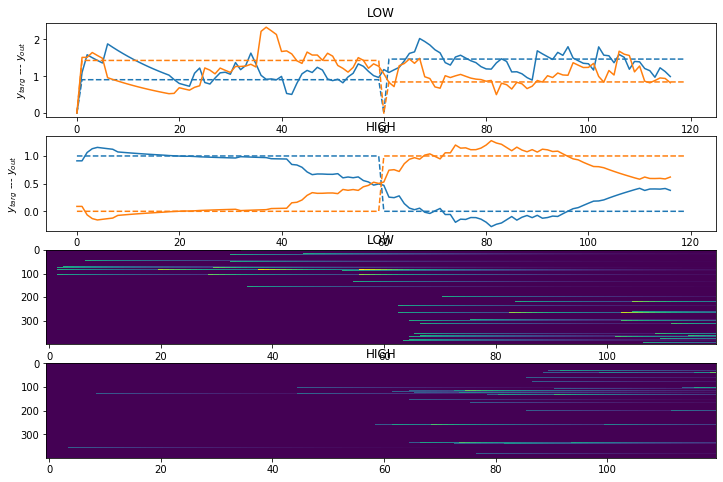

0.19574031707875217
0.07684085697506393


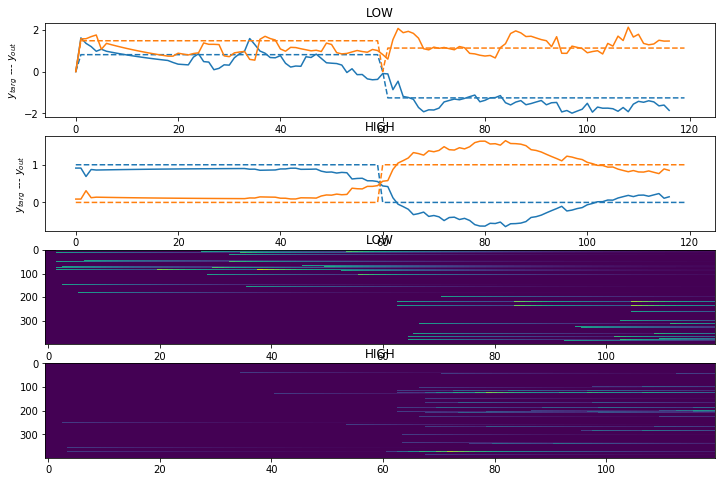

0.314634368069486
0.05413679388616888


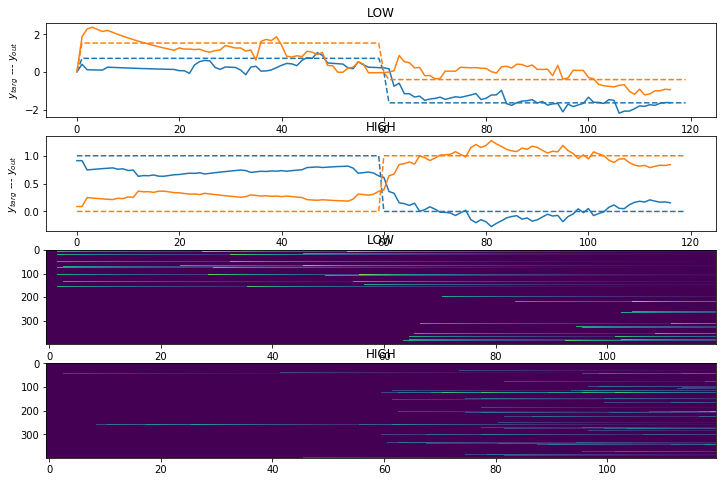

0.1383963992836522
0.16043430750997828


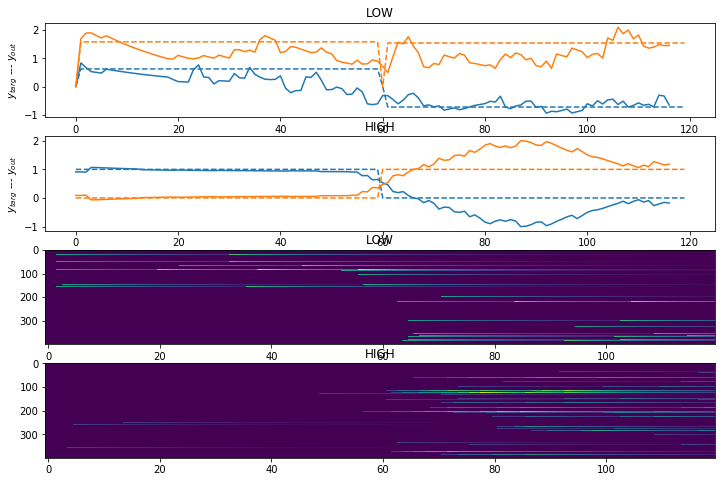

0.14813513835444755
0.25224756458320724


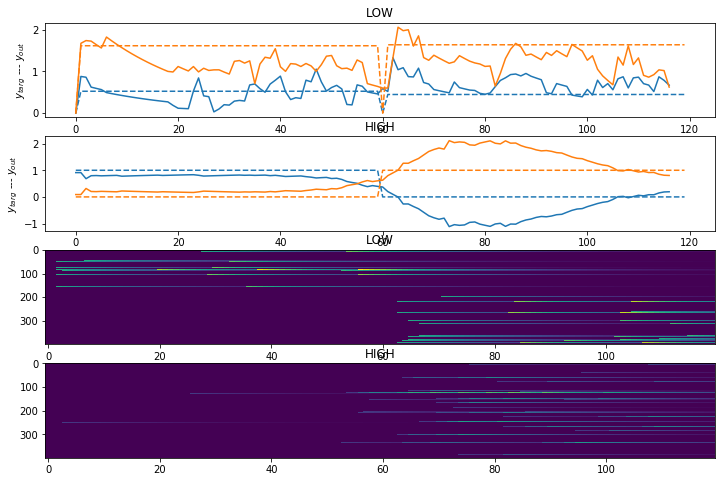

0.2205867592944513
0.05804835639274675


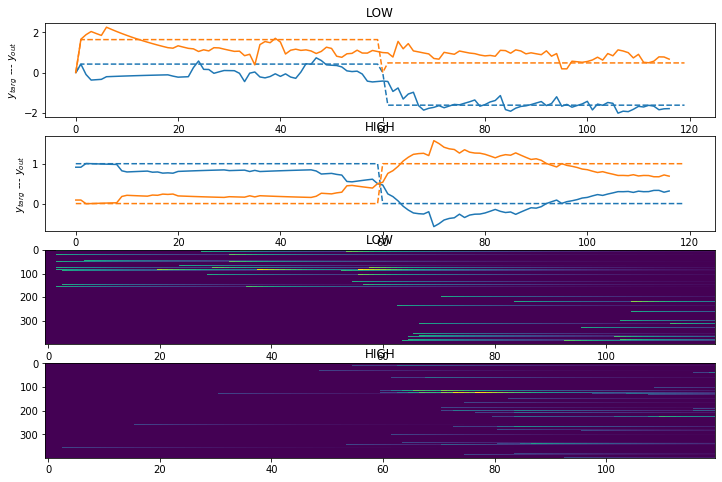

0.39595445309629623
0.17606287856860325


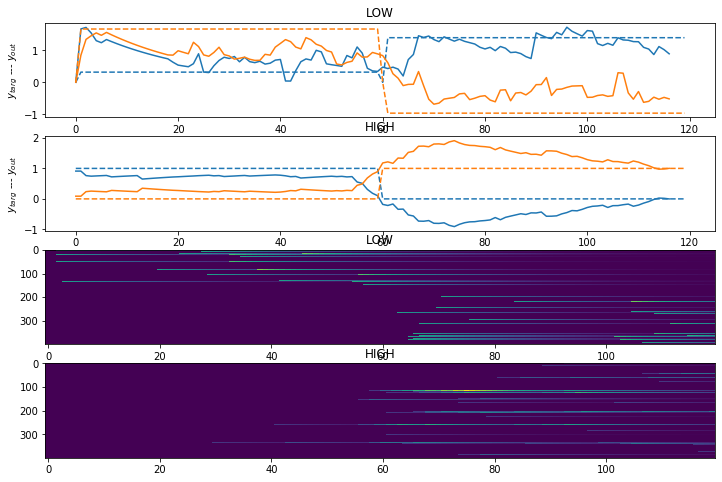

0.30524794034346725
0.11411420188202522


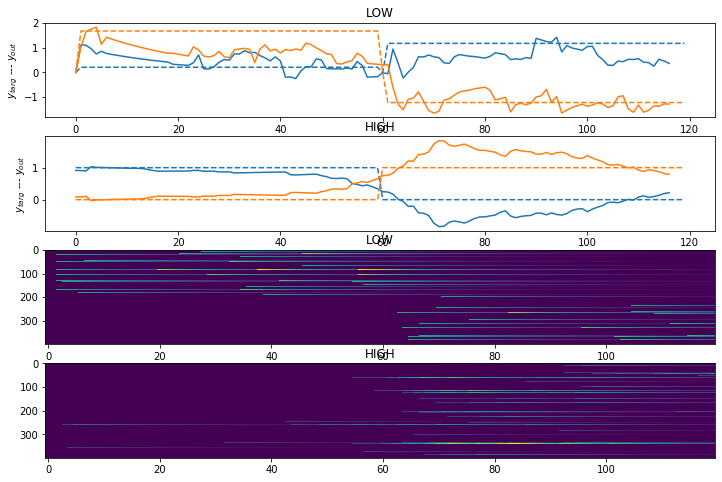

0.1932048218377718
0.17230880368728993


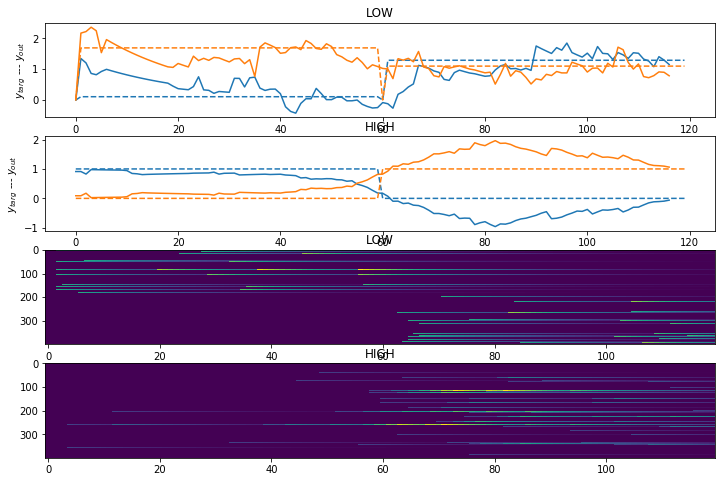

0.1798058359553626
0.16314316778528604


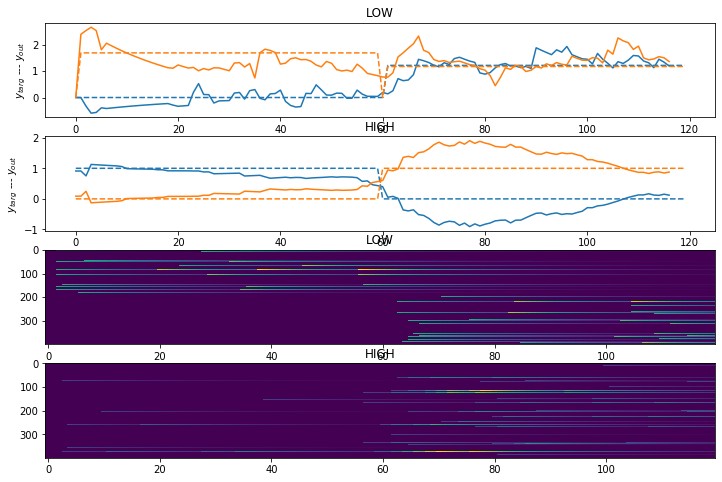

0.17476610947578308
0.14659012287517134


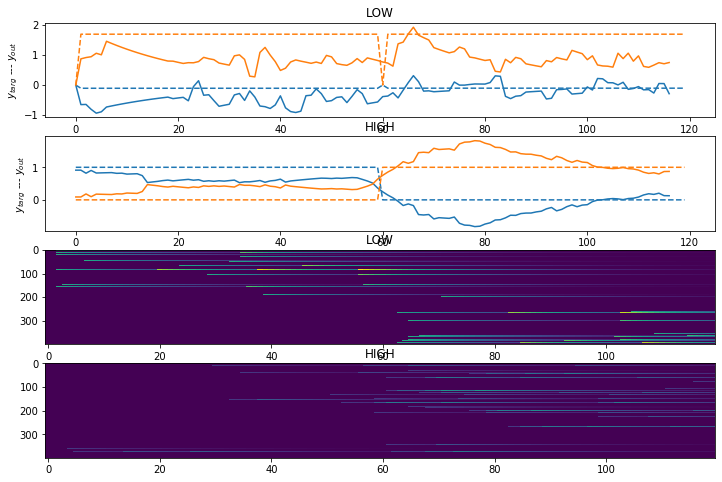

0.20911413885319285
0.48888583489980353


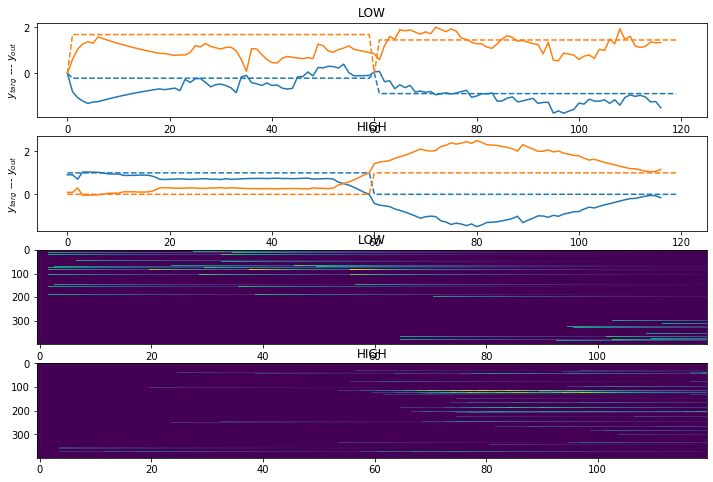

0.2580117510166883
0.1309189983765057


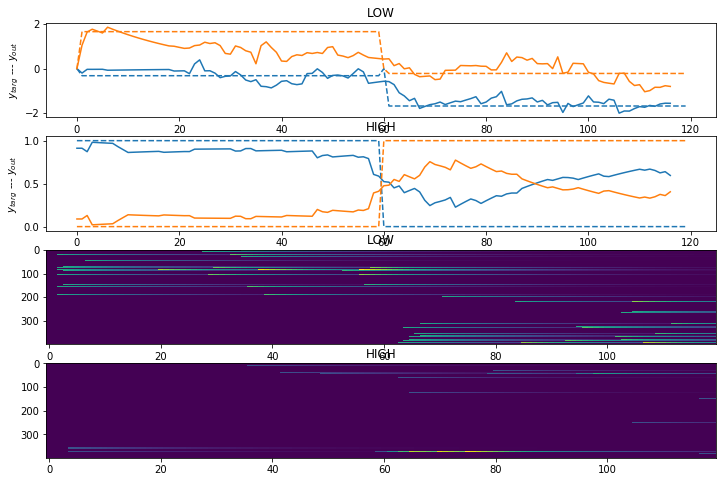

0.48052863283683606
0.046335877267240755


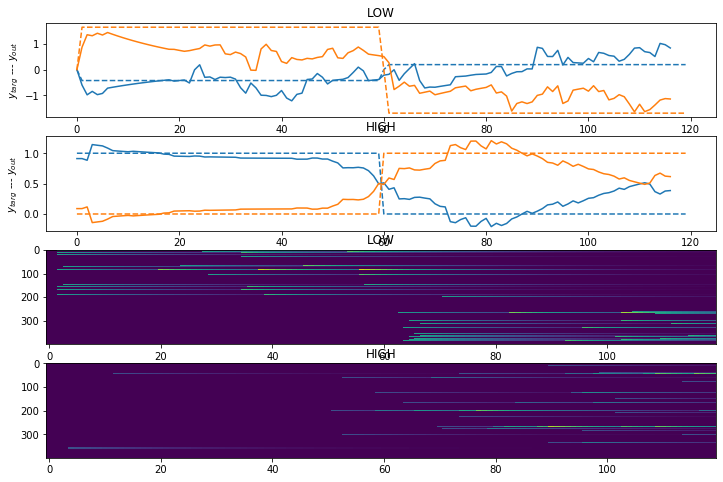

0.267091629028748
0.038961064169860754


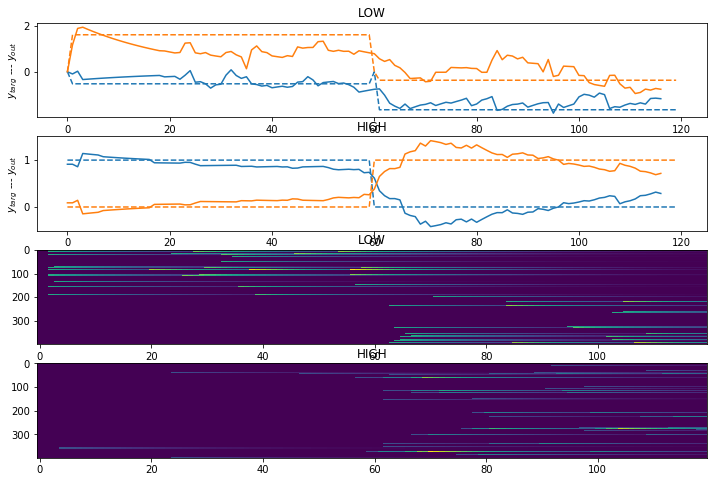

0.16039052513787141
0.06427465829805488


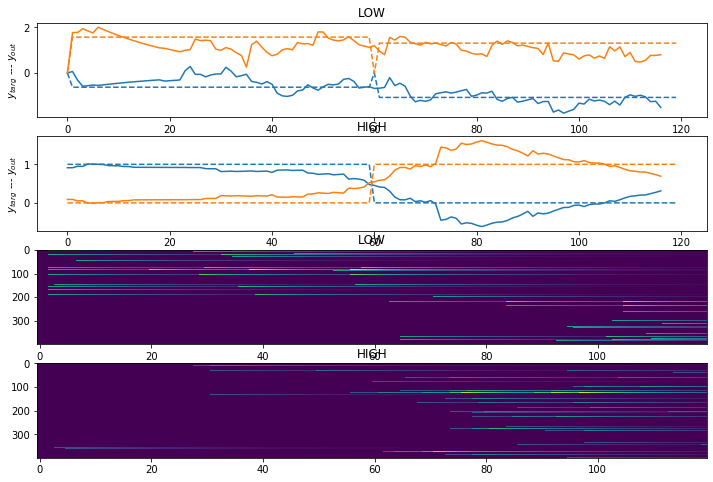

0.14483962451007115
0.0647461568375525


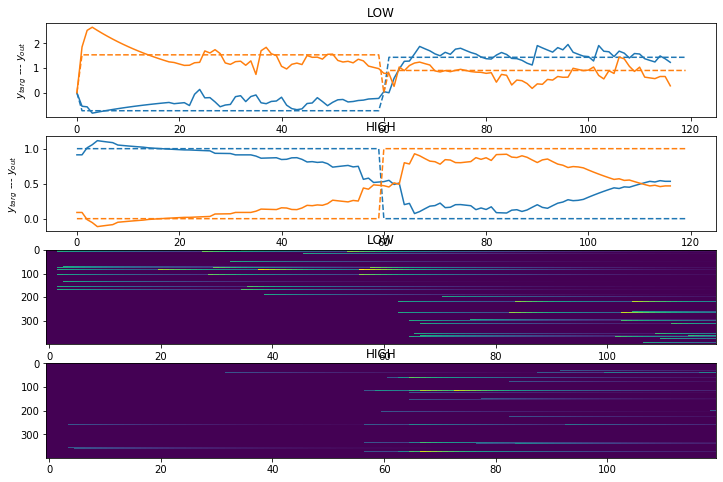

0.24231331244900456
0.0463529214910316


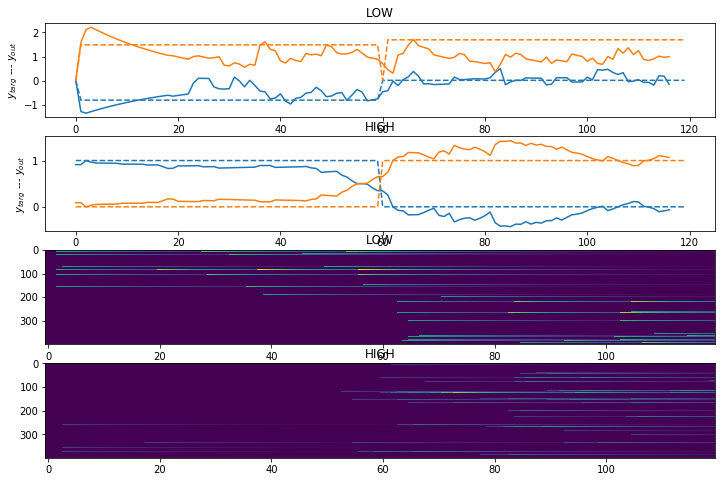

0.1545659219679379
0.20501987981416575


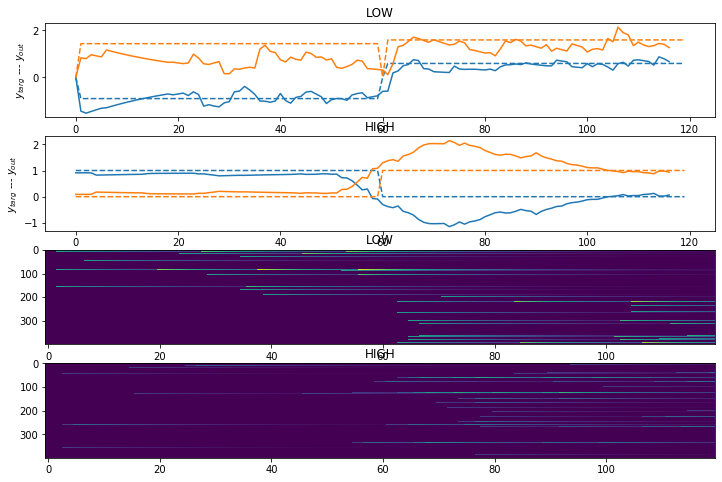

0.20104668827647523
0.34370113051512136


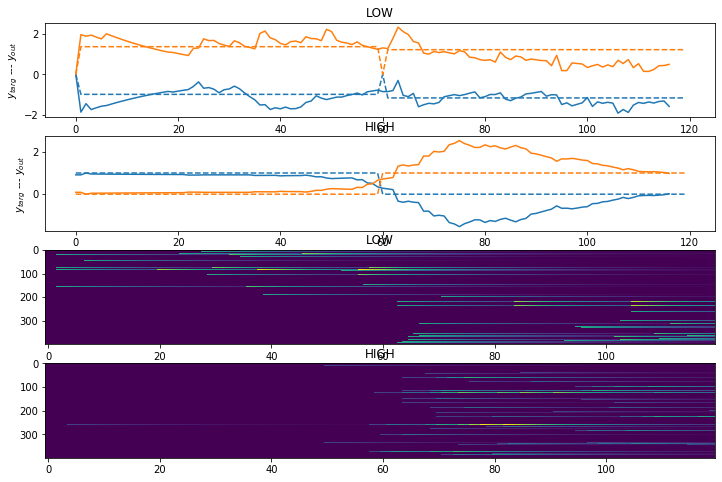

0.3422699566018065
0.05643328447117618


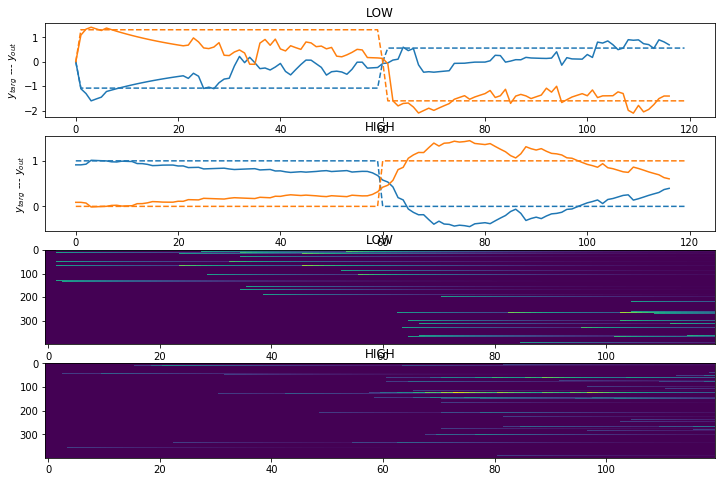

0.24217829051193518
0.18313505950232636


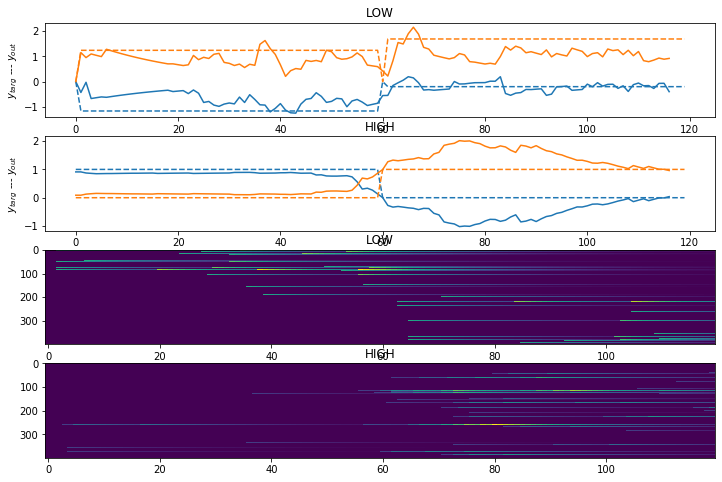

0.2470973847611649
0.1288051453027616


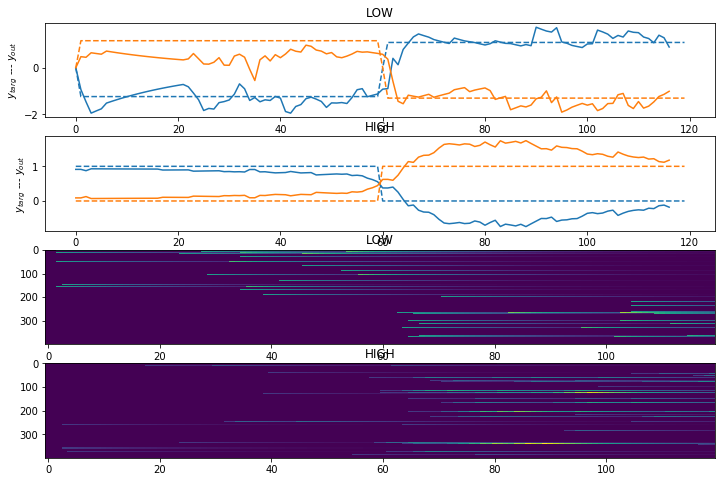

0.17882601468419498
0.12119349650239863


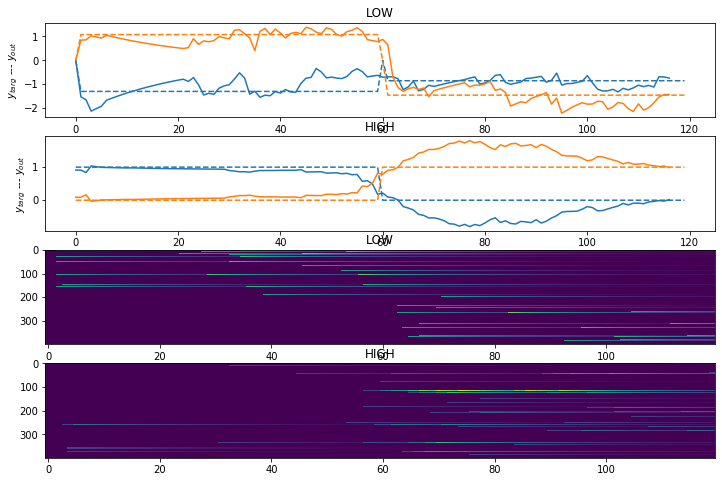

0.21016049974938045
0.13597903048206297


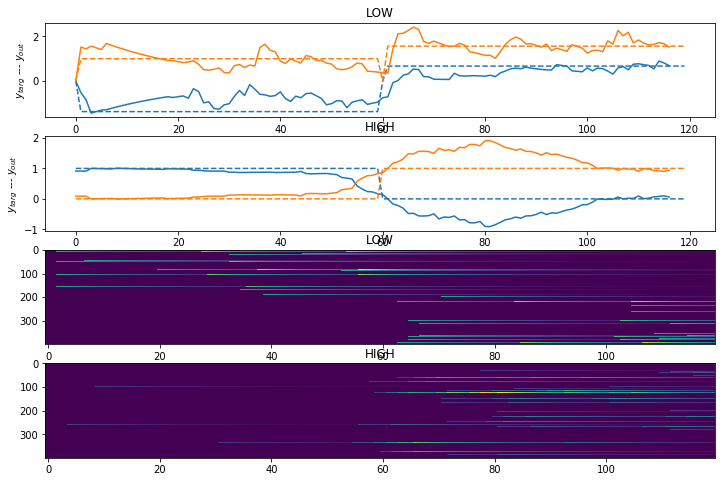

0.22073487425547733
0.03932256825063751


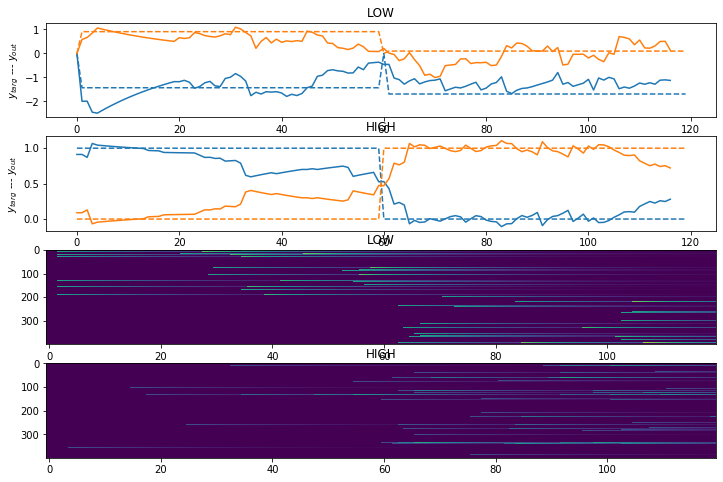

0.2600294096995121
0.5147757164814866


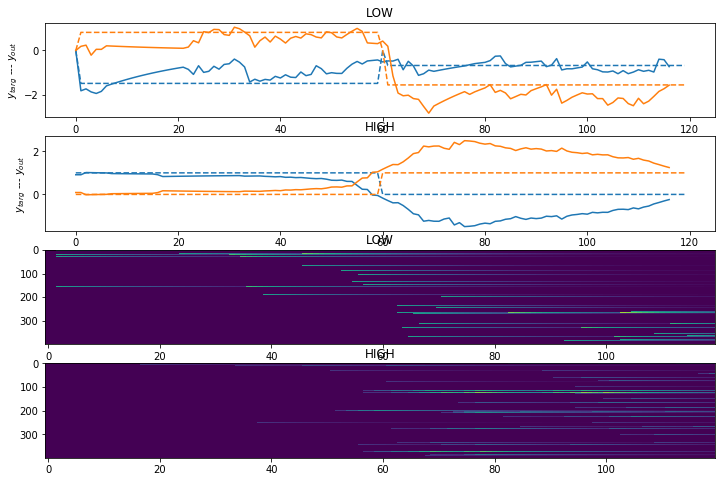

0.21678290702818978
0.09753171107681559


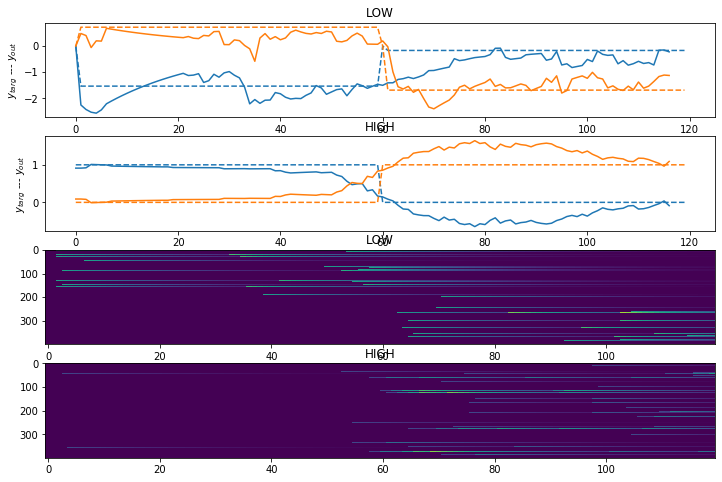

0.2139163706385072
0.04102600085632132


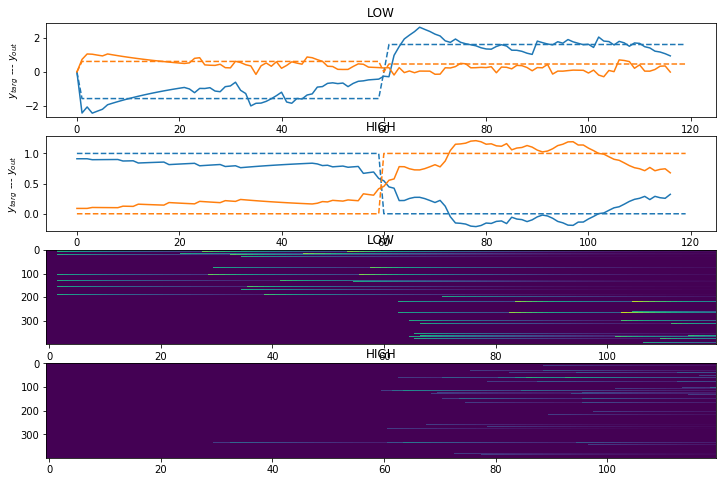

0.21062355683567743
0.1675277965318477


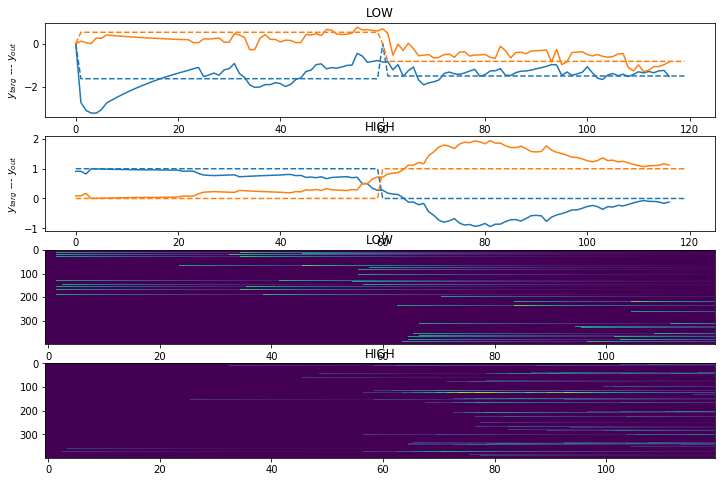

0.22297999696102483
0.07229038812282584


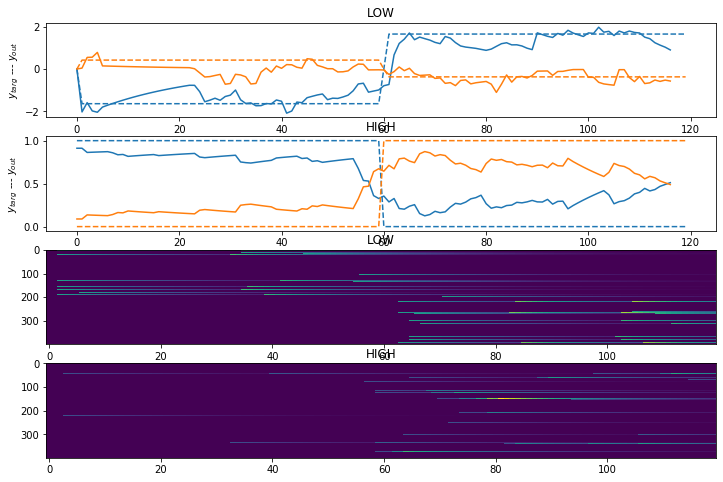

0.2978897126007624
0.5392582130002108


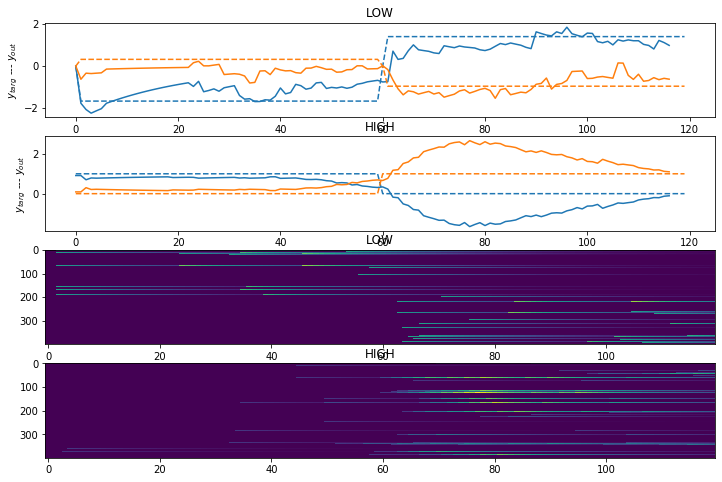

0.24720953545229957
0.12575465514402212


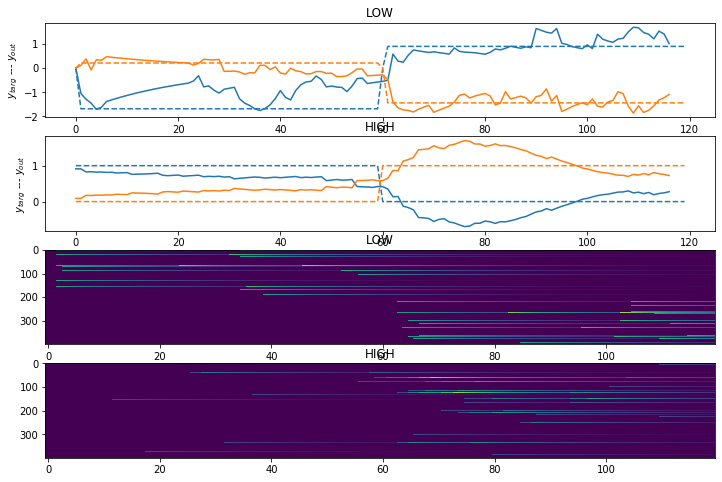

0.267046153181109
0.2548751419692954


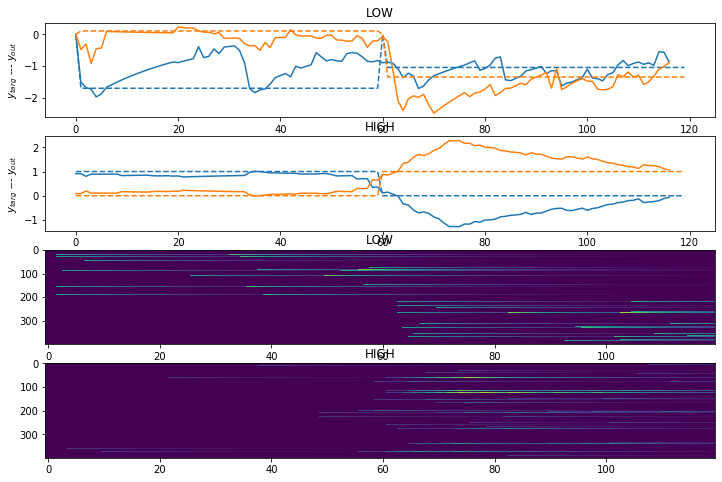

0.34755349576484507
0.059302779094445666


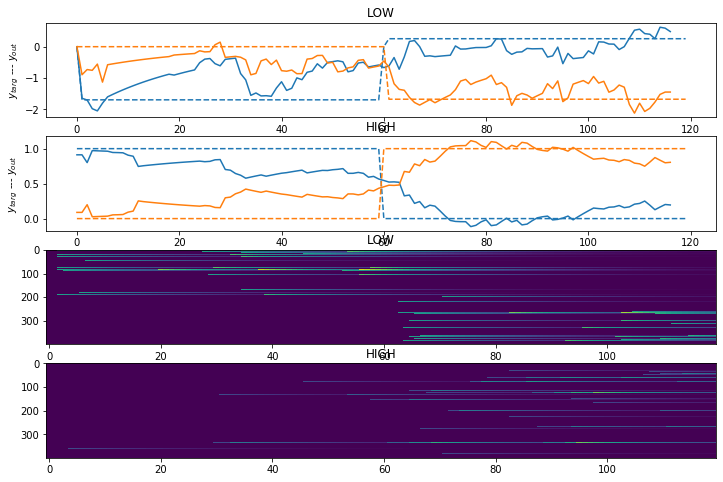

0.2680072653075852
0.08064791684984915


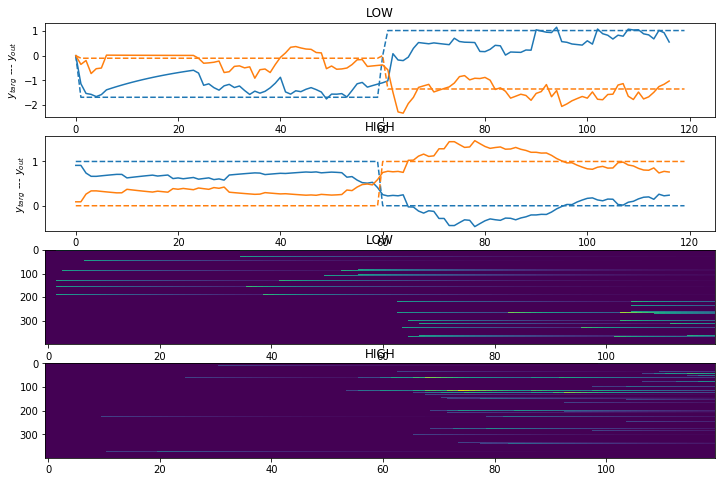

0.2737497844051309
0.4644181297561465


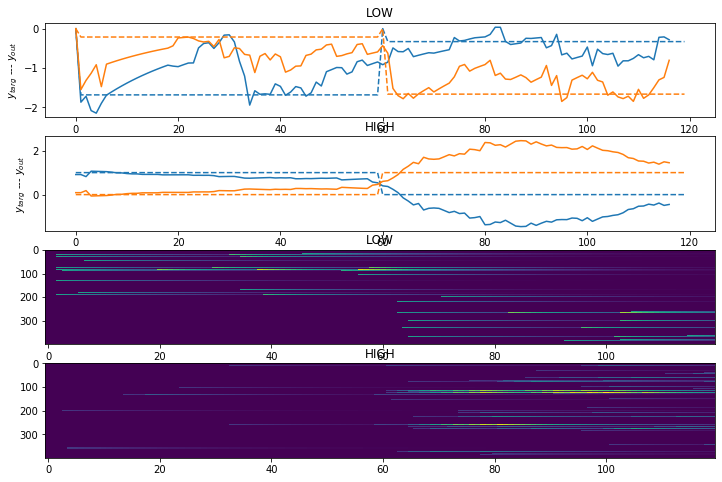

0.21670900383341274
0.06824647220416154


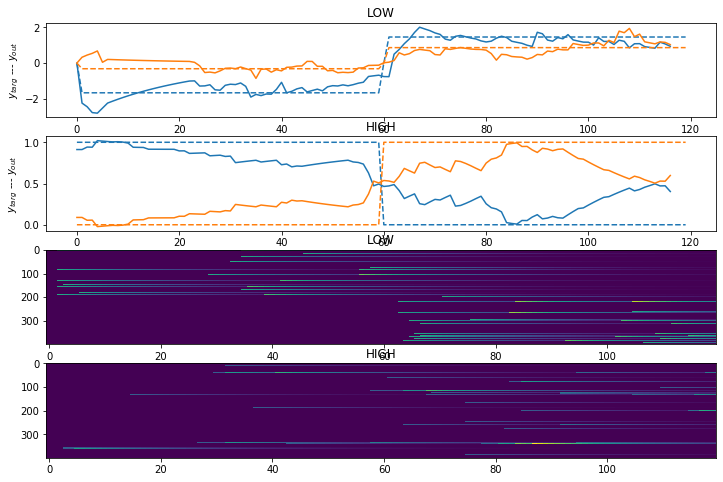

0.17361939867765214
0.03770070403742714


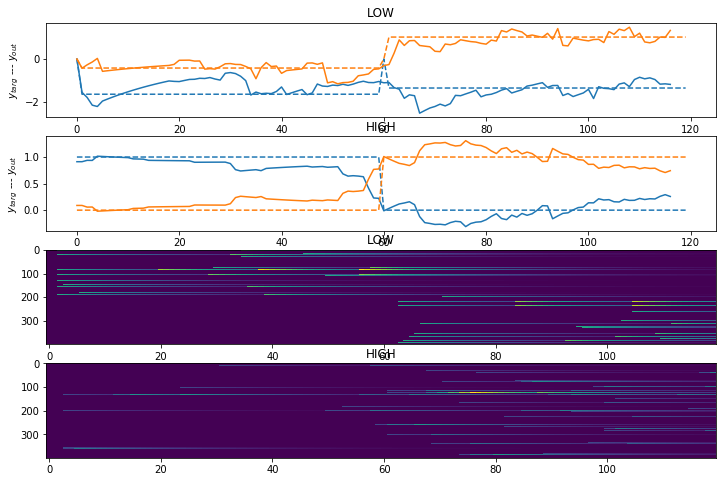

0.18672206023736732
0.3084751453700597


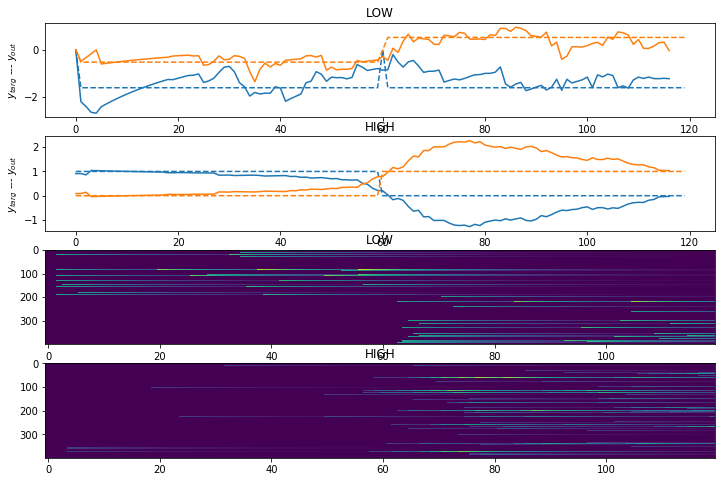

0.20673102508612892
0.04648597245503032


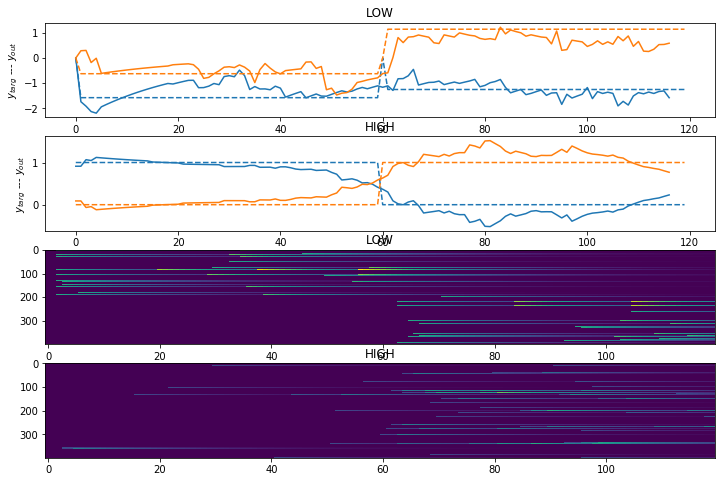

0.28777877925642203
0.08340559358608435


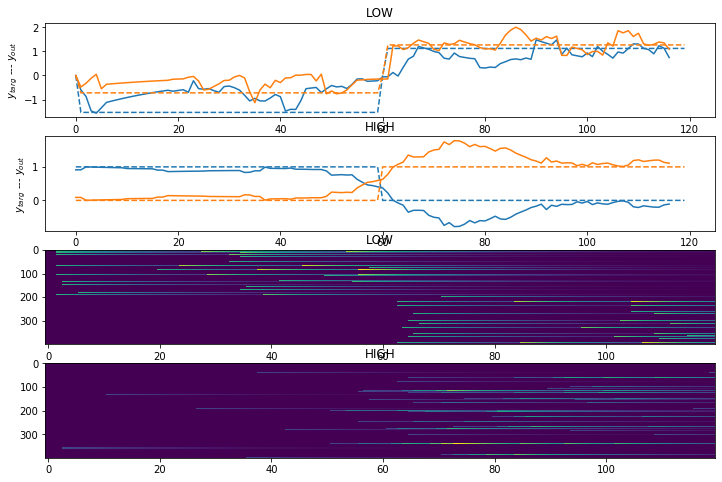

0.20386715925011933
0.14402429706221148


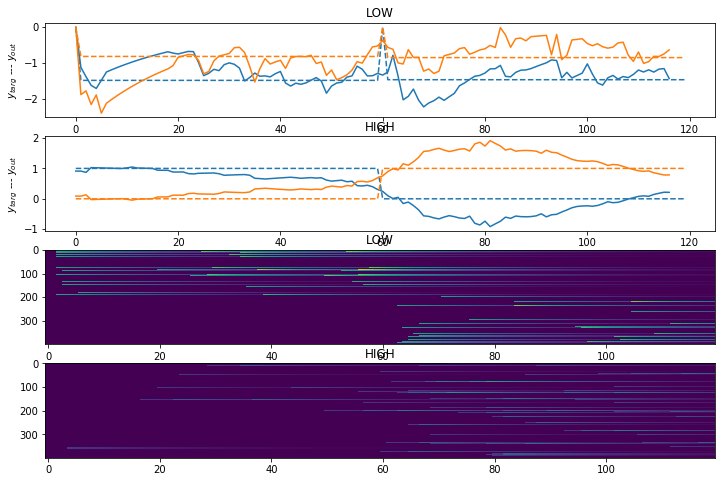

0.22665370362590626
0.1389199515593661


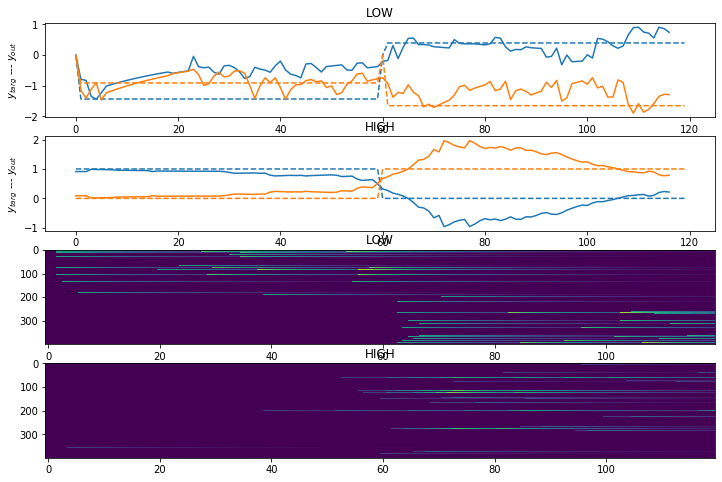

0.3491859608913761
0.06378638921443895


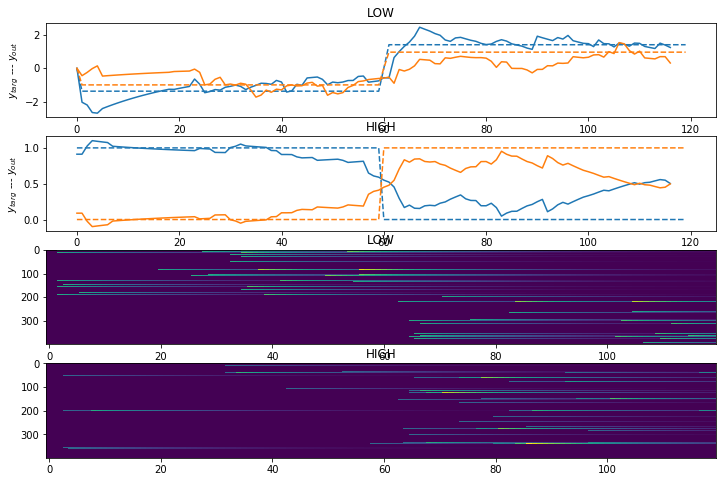

0.17662437179174806
0.15665908781319016


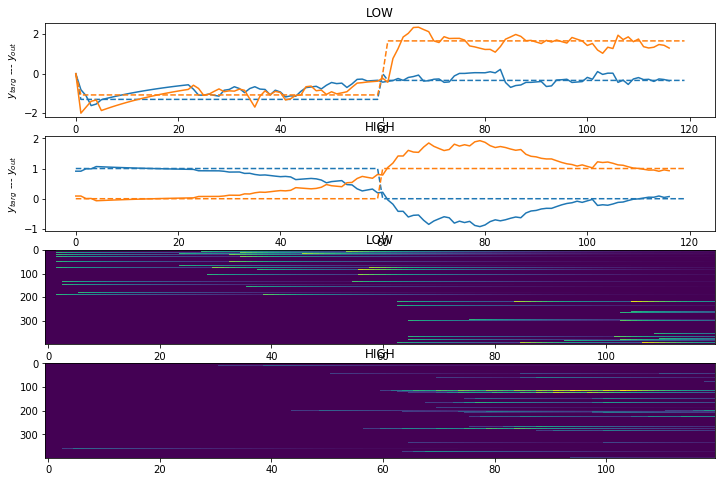

0.20173829817535657
0.7889753441552769


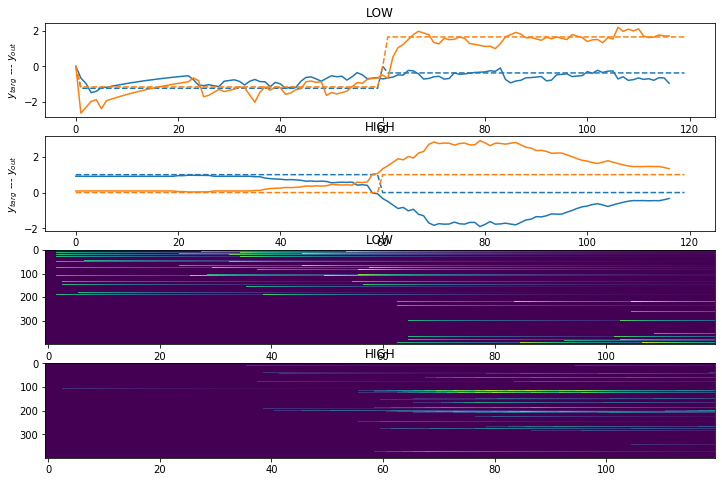

0.24946817312563174
0.09118818696552614


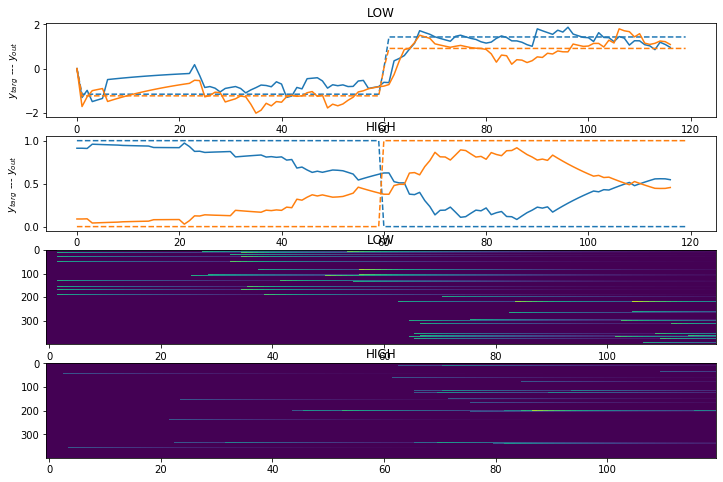

0.21254986931922526
0.15613683389396632


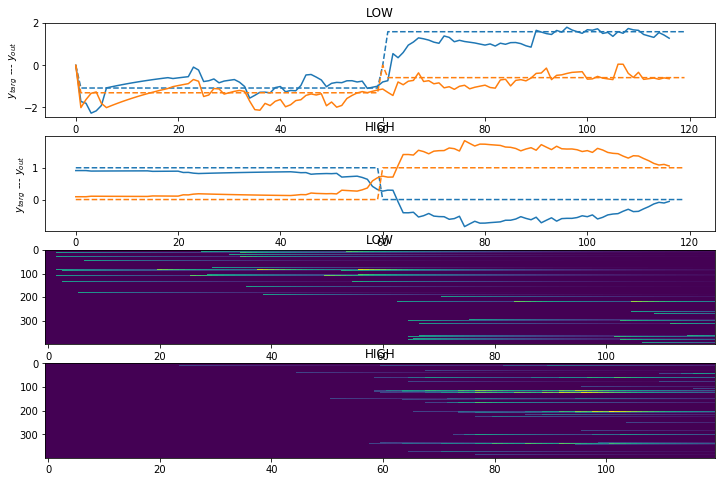

0.22050145246184047
0.1968618318895106


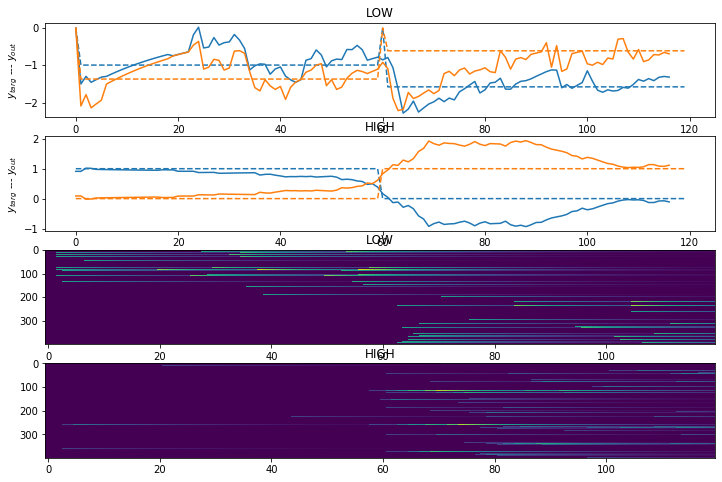

0.20140849803970637
0.06148225950591016


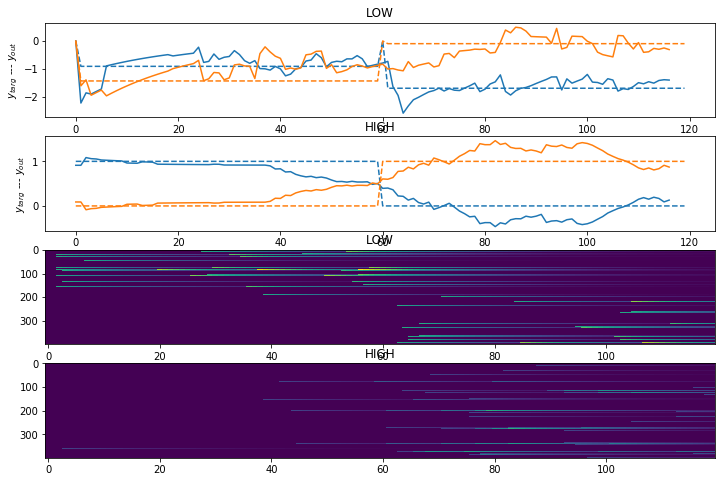

0.21372076042404028
0.08812552639939393


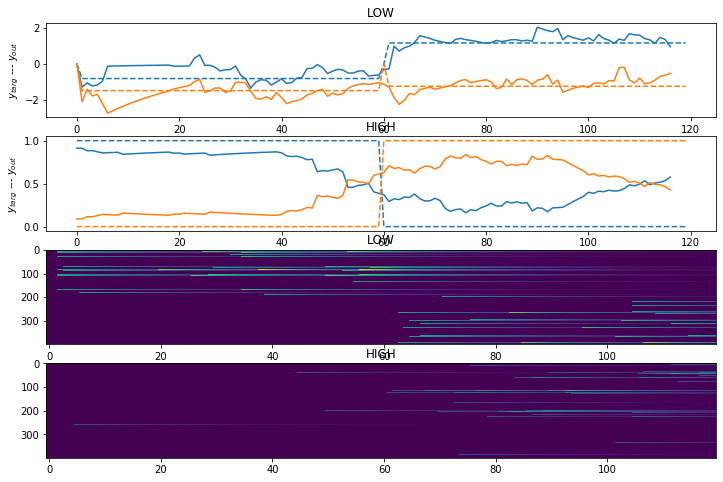

0.18742514996058784
0.024558493135980682


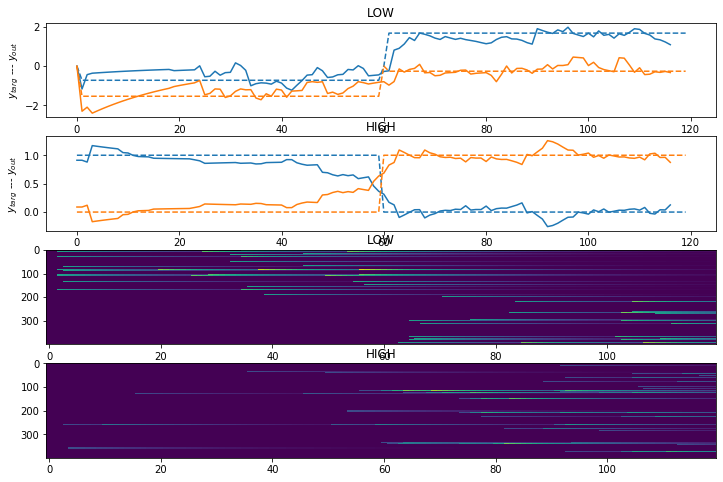

0.24373871878627665
0.29069510879154914


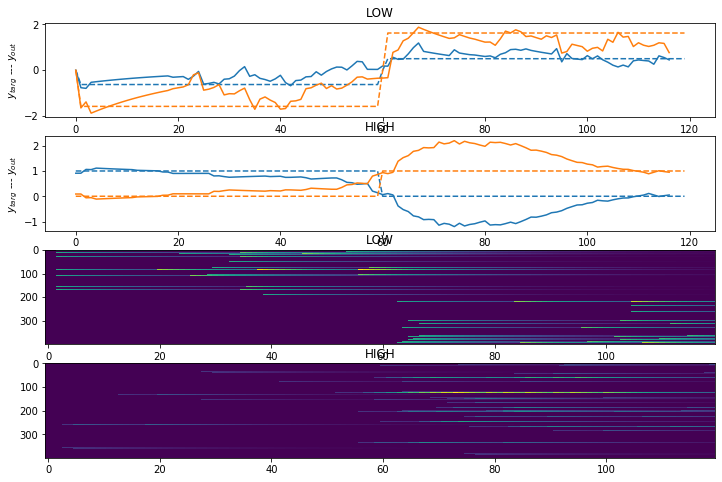

0.2014195874980418
0.32534706952585885


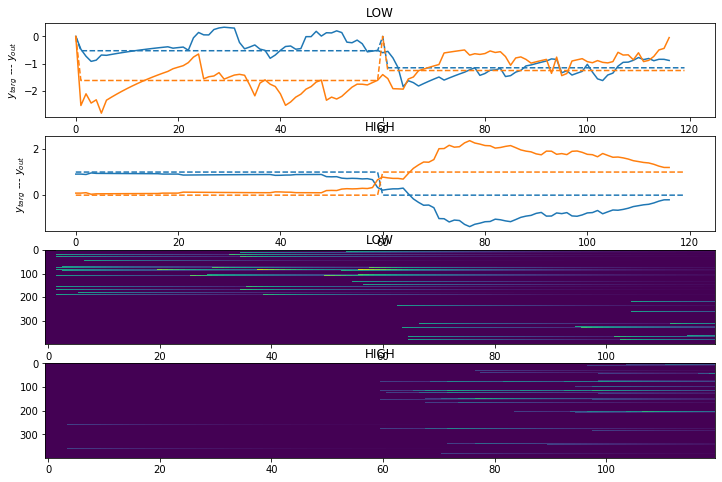

0.2971575729356873
0.4143411933869903


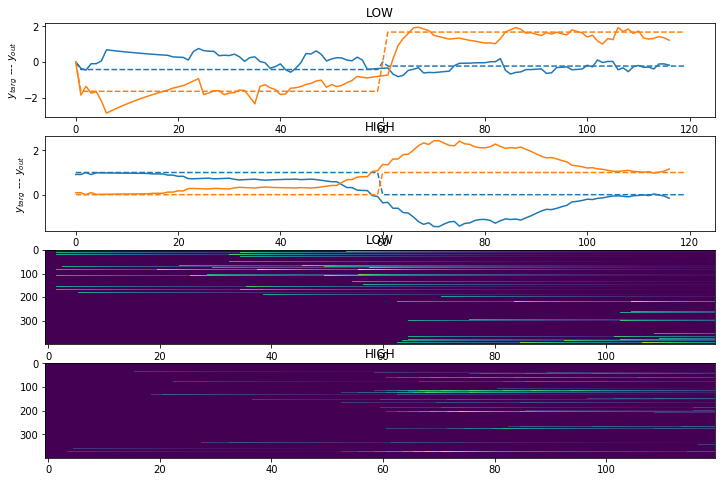

0.232996306218766
0.13946162856381997


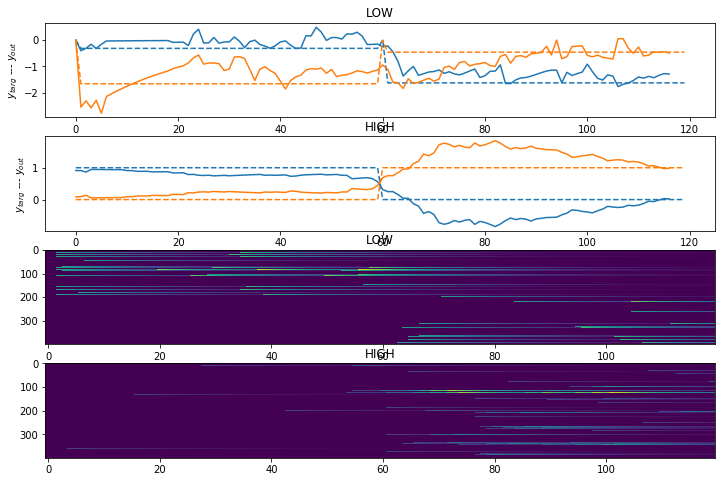

0.30860948537924354
0.046749460149189986


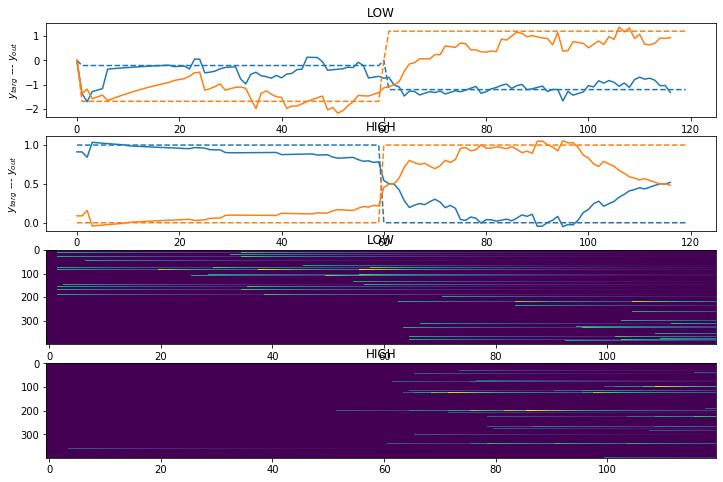

0.29460968673144033
0.2855302180062806


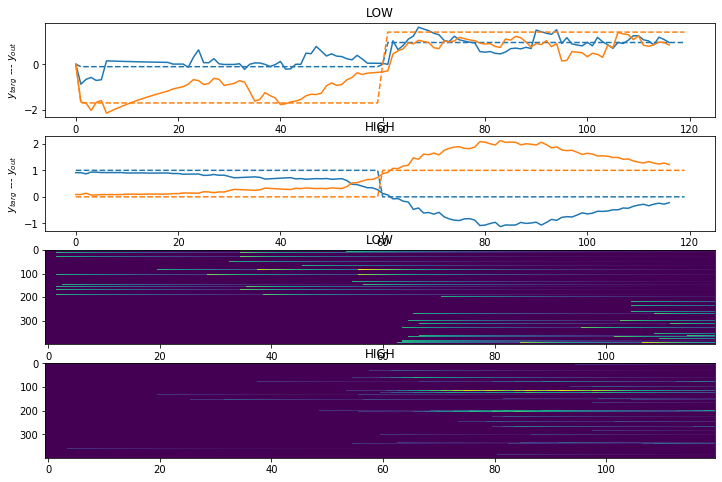

0.3064180930707305
0.29887791201572345


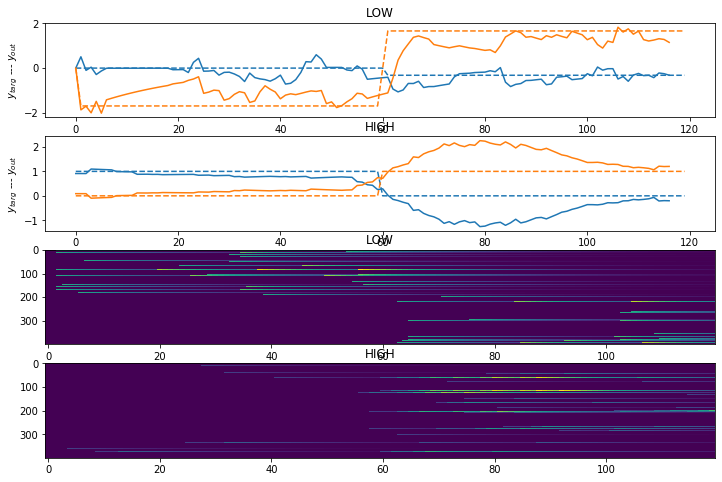

0.20029908050472794
0.06173716604653933


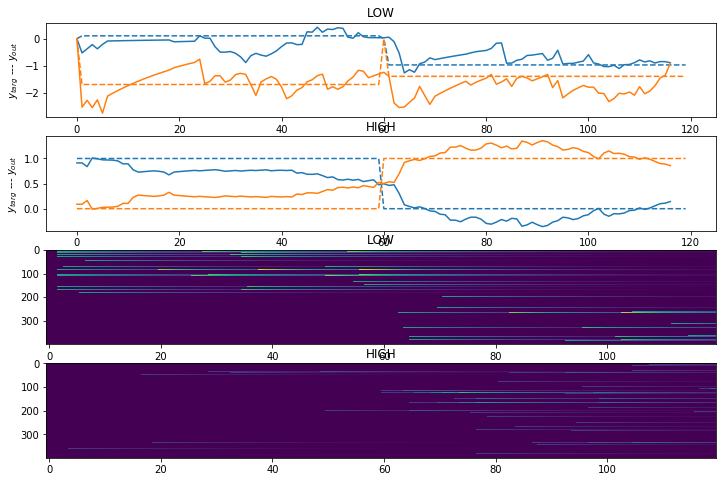

0.11912015829574606
0.03621077964007473


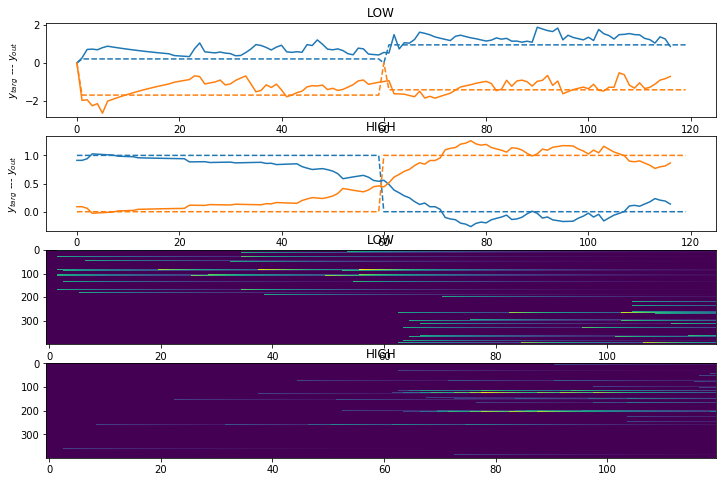

0.1926677346225722
0.12176158110686787


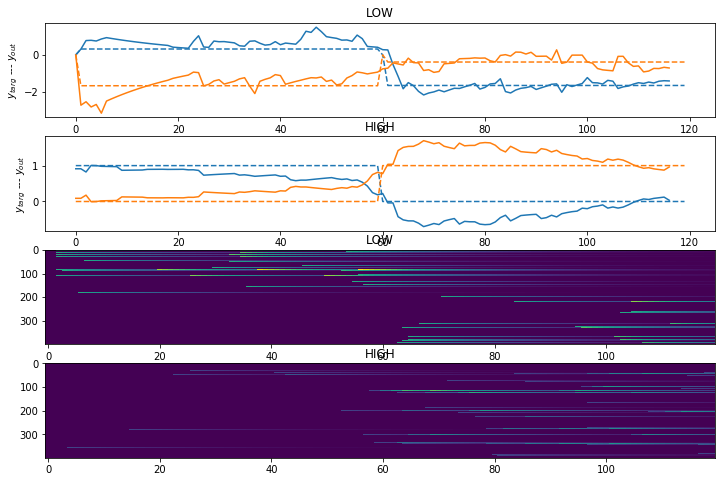

0.24724715429444508
0.04950917994023288


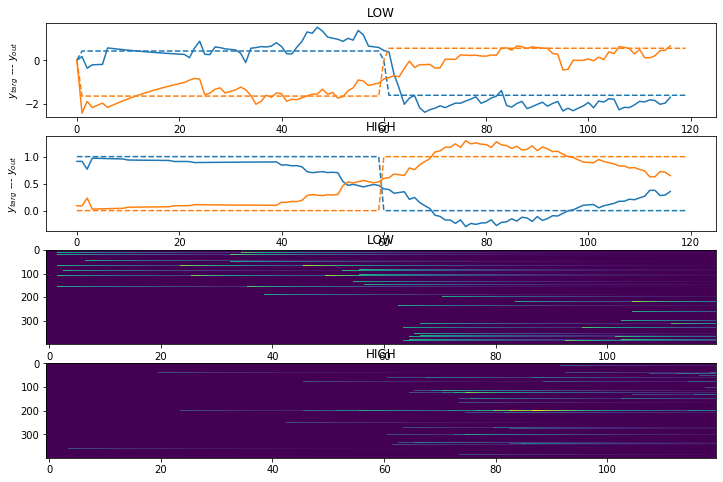

0.1621807326325863
0.052778636192880375


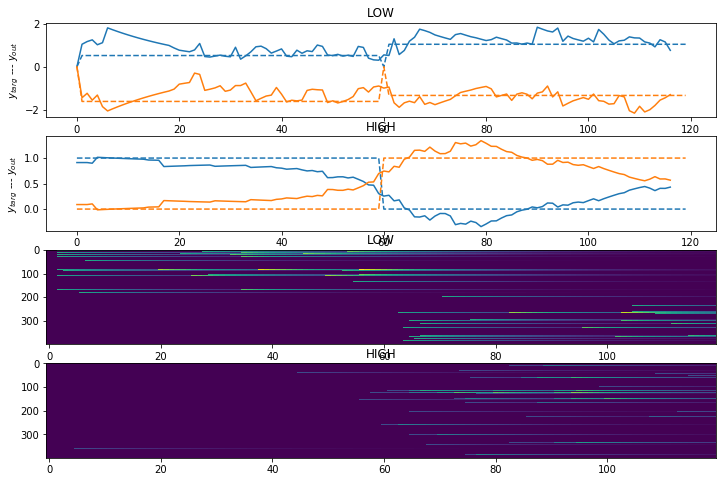

0.18821306459470377
0.05787583039990494


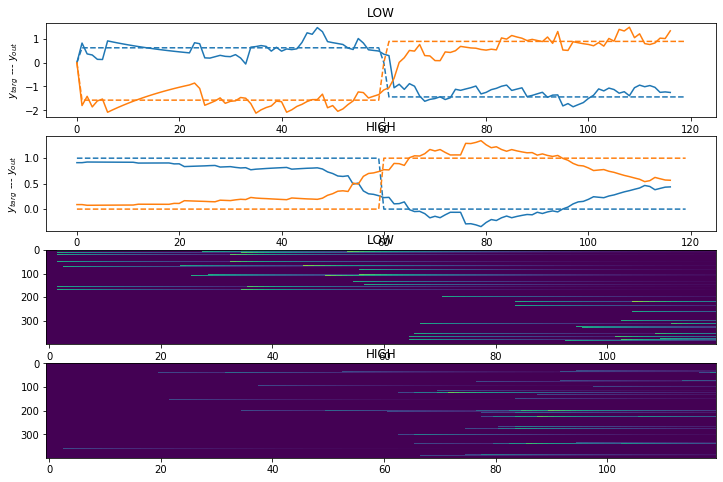

0.2645047437115102
0.1263354345208927


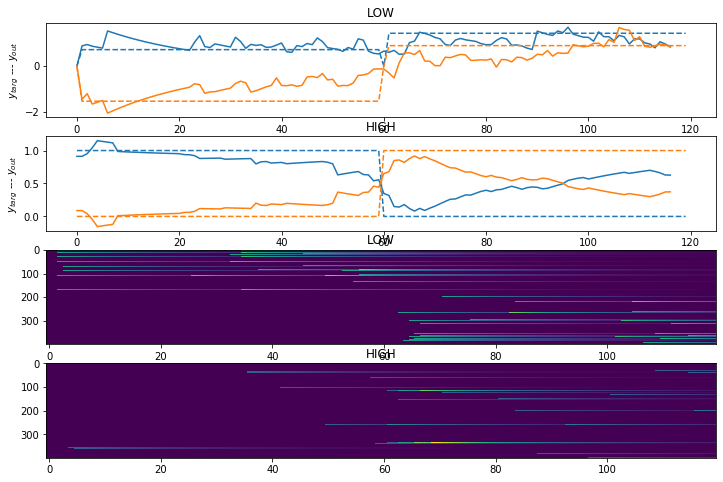

0.2332354583004242
0.030268472194309972


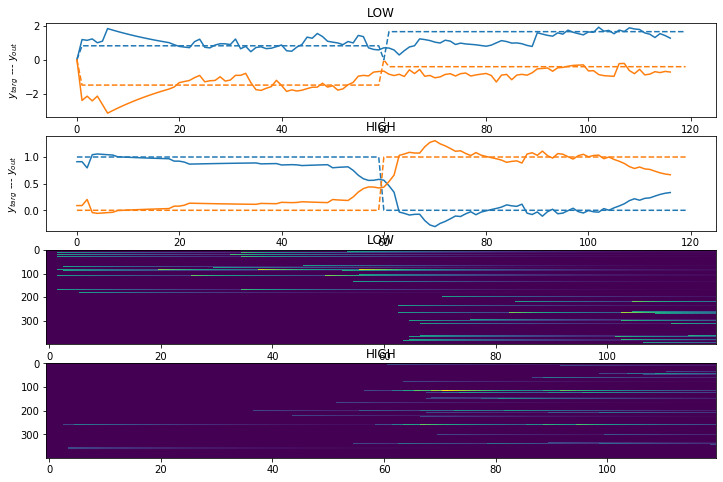

0.2653228309601205
0.05481998228727779


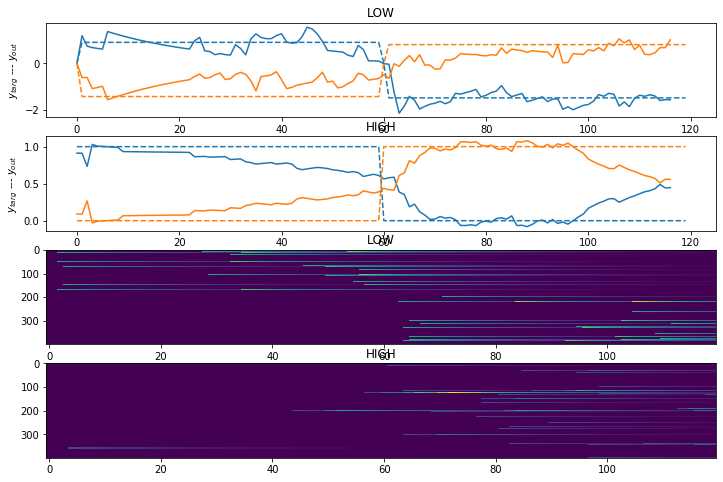

0.2798533167547998
0.20680135994272955


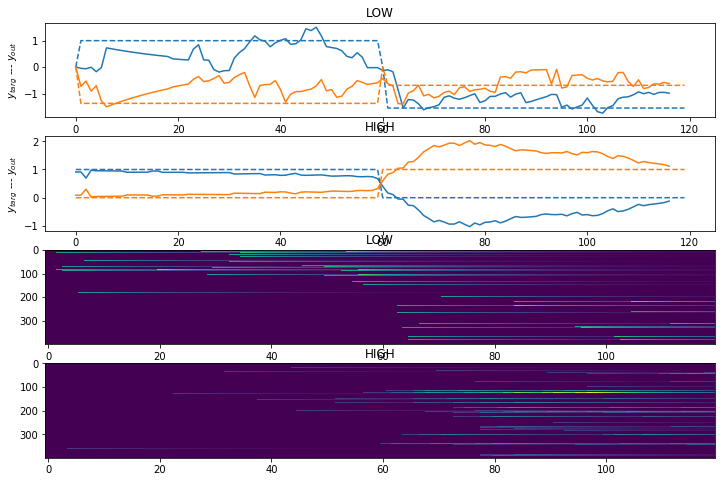

0.2008805955331759
0.18351665792634936


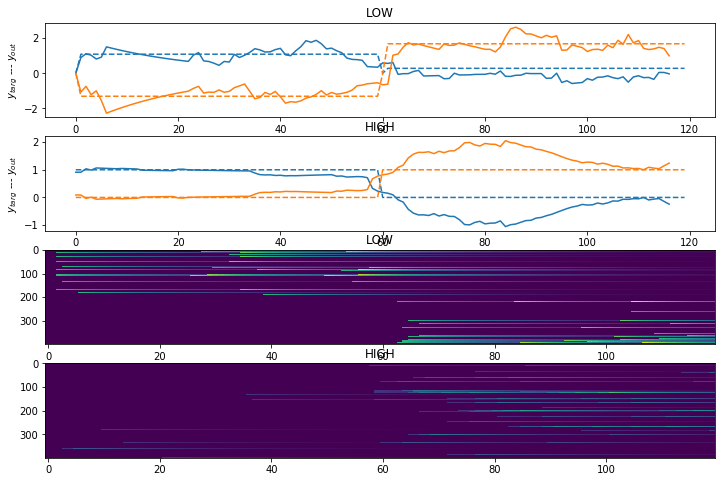

0.25900652971330146
0.28301259212725943


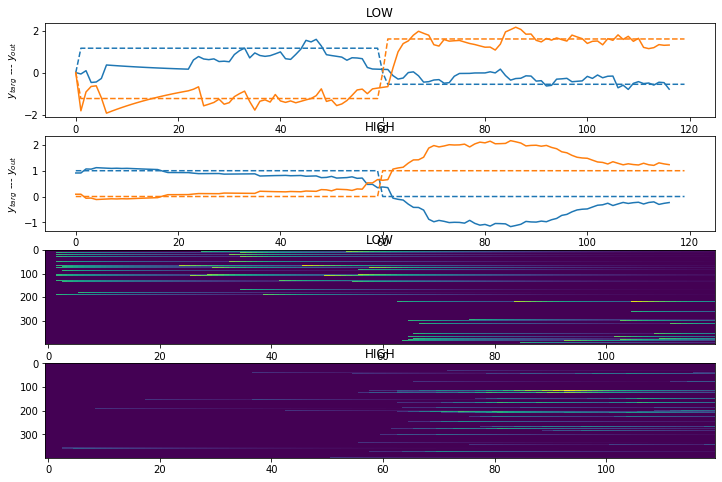

0.30240651976438393
0.041356414763737914


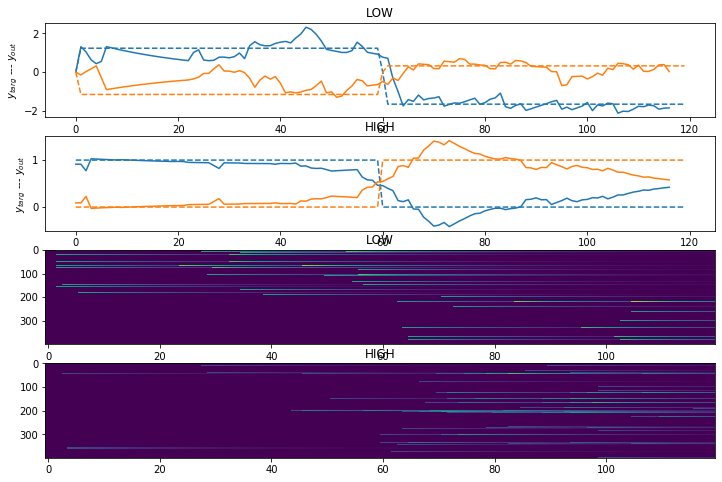

0.1953869796941815
0.058695968264534076


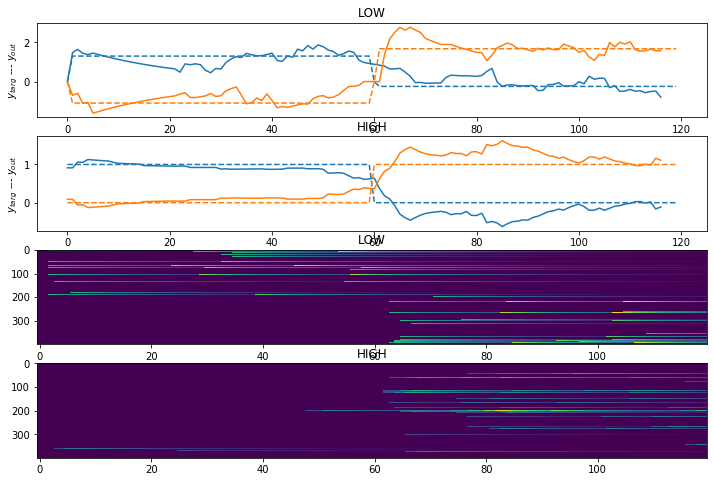

0.2097127113852694
0.06620326224896875


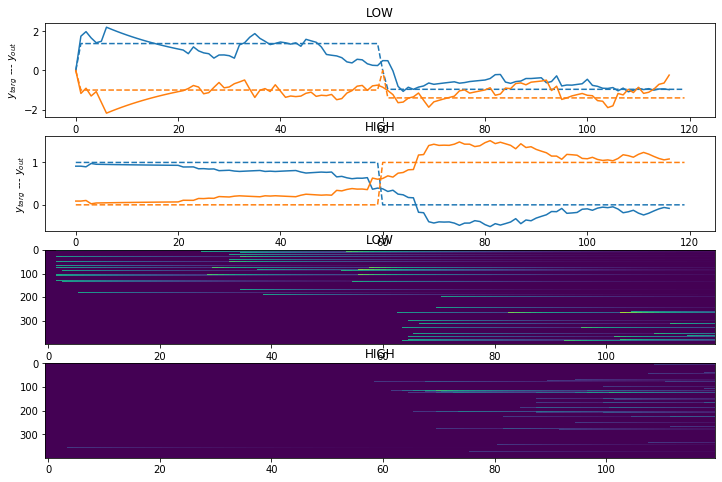

0.18892880335195875
0.20144866802444794


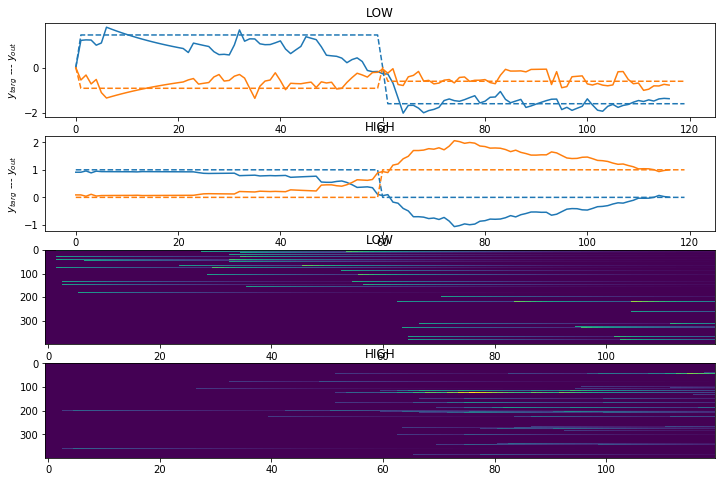

0.21157494936674398
0.07039161620571069


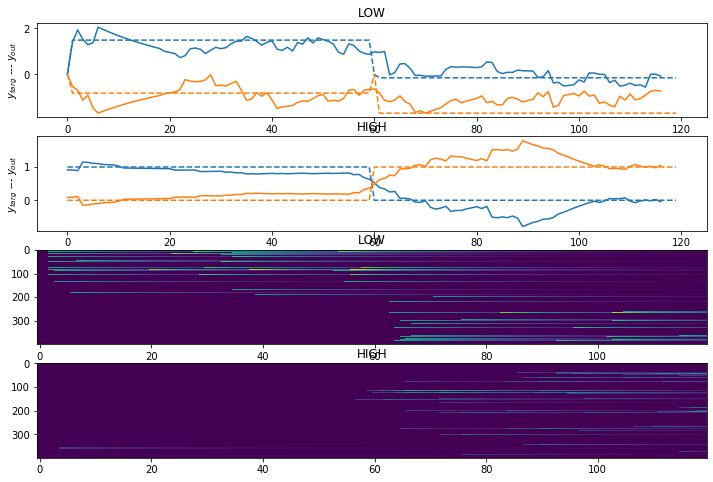

0.2039221646476091
0.6287928255088459


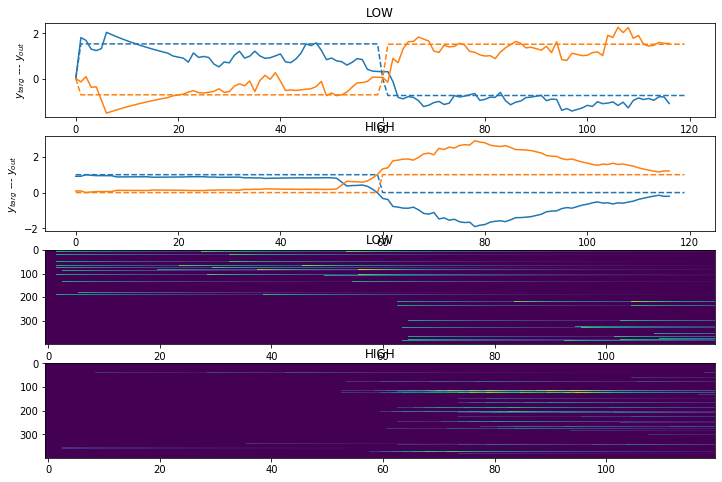

0.28748084948635005
0.039848044635257214


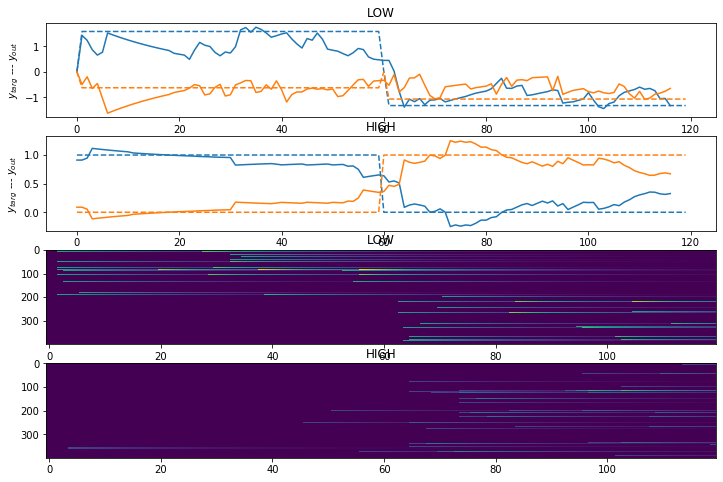

0.12186207915070463
0.07311041125943696


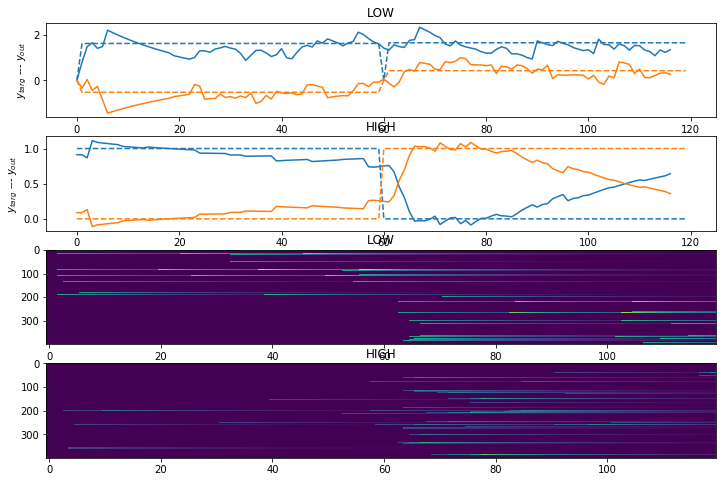

0.28639823760309746
0.13823232531342966


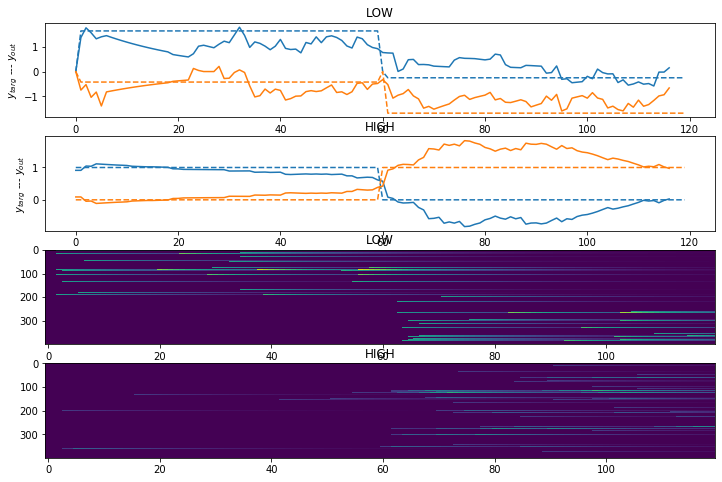

0.30400296036274055
0.6753655331671683


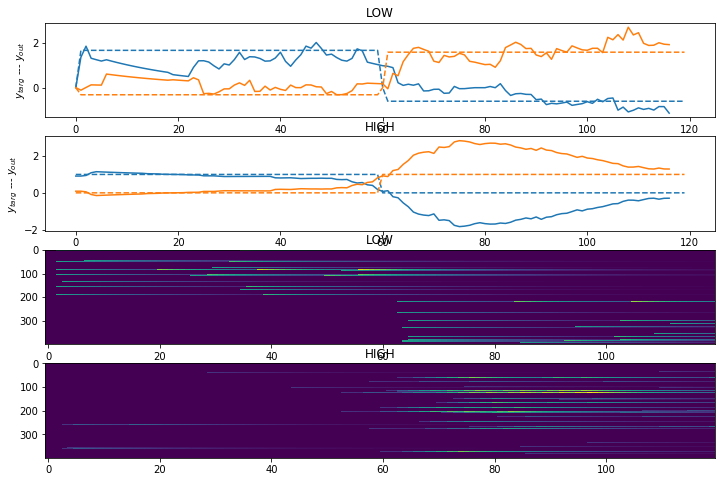

0.19151635736670808
0.1194923750303449


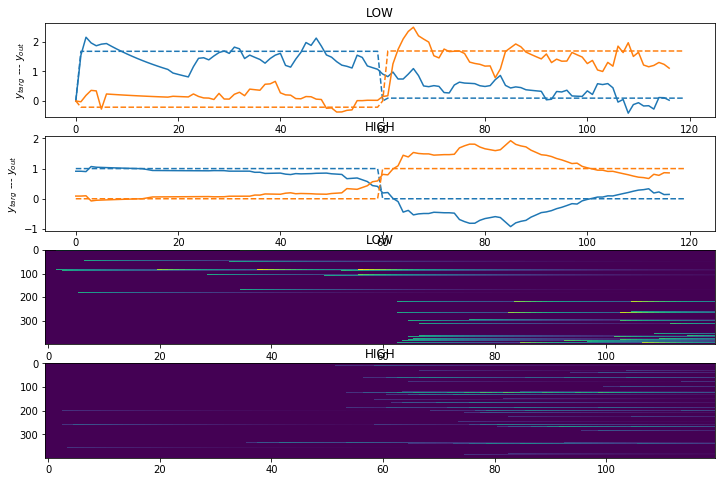

0.173295260048438
0.1157314820169783


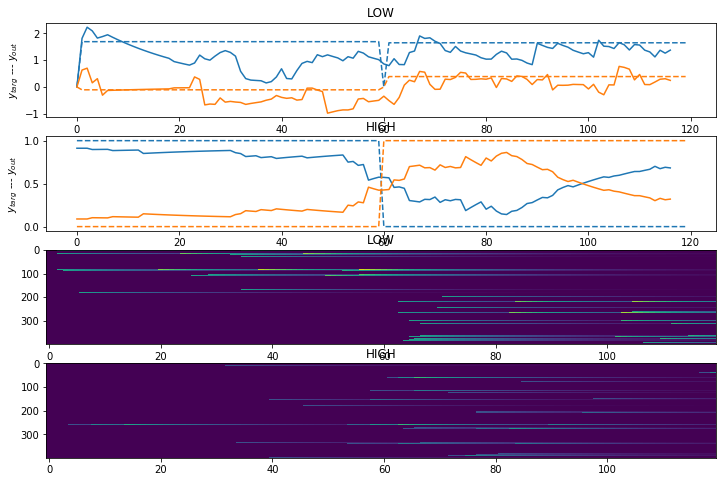

In [399]:
lttb_low.T = tb+tf
lttb_high.T = tb+tf

for cont_index in range(n_examples):
    
    lttb_low.initialize(par)
    lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
    lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
    
    lttb_high.initialize(par_high)
    lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
    lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
    
    #run simulation
    
    for t in range(lttb_low.T-2):
        if(t<tb):
            lttb_low.cont = np.array([1,0])
        else:
            lttb_low.cont = np.array([0,1])
        lttb_low.step(apicalFactor = apicalFactorTest)
    
    for t in range(lttb_high.T-2):
        lttb_high.cont = np.array([0,0])
        lttb_high.step(apicalFactor = apicalFactorTest)
    
    SR_low = lttb_low.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
    Y_low = lttb_low.Jout@SR_low
    mse_ro_train_low = np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
    
    SR_high = lttb_high.B_filt_rec[:,1:-2] # lttb.S_filtRO[:,1:-2]
    #Y_high = lttb_high.Jout@SR_high
    Y_high = lttb_high.Jout@SR_high + np.tile(Bias,(117,1)).T
    mse_ro_train_high = np.std(lttb_high.y_targ[:,1:-2] - Y_high)**2
    
    print(mse_ro_train_low)
    print(mse_ro_train_high)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(411)
    plt.title('LOW')
    for n in range(len(Y_low)):
        plt.plot(Y_low[n].T, color='C'+str(n))
        plt.plot(lttb_low.y_targ[n].T, ls='--', color='C'+str(n))
    #plt.plot(np.array(context),'--')
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    
    plt.subplot(412)
    plt.title('HIGH')
    for n in range(len(Y_high)):
        plt.plot(Y_high[n].T, color='C'+str(n))
        plt.plot(lttb_high.y_targ[n].T, ls='--', color='C'+str(n))
    #plt.plot(np.array(context),'--')
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    
    plt.subplot(413)
    plt.title('LOW')
    plt.imshow(lttb_low.B_filt[0:400,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    plt.subplot(414)
    plt.title('HIGH')
    plt.imshow(lttb_high.B_filt_rec[0:400,:],aspect='auto')
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [298]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [401]:
def make_test(btn, targ, show_plot=True, use_HighNetwork=False):
    
    TIME_TEST = 1500
    
    t_reach_btn = TIME_TEST
    t_reach_targ = TIME_TEST
    
    par['T'] = TIME_TEST
    lttb_low.T = TIME_TEST
    lttb_low.initialize(par)
    lttb_low.y_targ = np.zeros((lttb_low.O,lttb_low.T))
    
    if use_HighNetwork:
        par_high['T'] = TIME_TEST
        lttb_high.T = TIME_TEST
        lttb_high.initialize(par_high)
        lttb_high.y_targ = np.zeros((lttb_high.O,lttb_high.T))
    
    #targ_test = train_targs[cont_index]
    #btn_test = train_bttns[cont_index]

    #theta = 30
    #theta = theta/180*np.pi
    #targ_test = (np.random.rand(2)-.5)
    #btn_test = (np.random.rand(2)-.5)
    
    btn_radius = 0.1
    #btn_dist = 1.0
    #btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    #btn = btn_test
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init=init, targ=targ, btn=btn)

    agen = init
    
    cont_noise = 0.05
    
    R = 0

    ACTIONS = []
    ACTIONS_HIGH = []
    POSITION = [] # np.zeros((2,TIME_TEST-2))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    
    lttb_low.I_clock[:,0] = state # lttb.I_clock_collection[cont_index][:,0]
    lttb_low.cont = np.array([1,0])
    
    if use_HighNetwork:
        lttb_high.I_clock[:,0] = state # lttb.I_clock_collection[cont_index][:,0]
        lttb_high.cont = np.array([0,0])
        
    closed_loop = True

    context = []

    btn_on = False

    for t in range (TIME_TEST-2):
        
        if not use_HighNetwork:
            
            if not btn_on:
                lttb_low.cont = np.array([1,0]) + np.random.normal(loc=0, scale=cont_noise, size=2)
            else:
                lttb_low.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)
            
            if closed_loop:
                lttb_low.I_clock[:,lttb_low.t+1] = state
                if np.sqrt( np.sum((agen - btn)**2) ) < btn_radius:
    
                    btn_on = True
                    t_reach_btn = t
                    lttb_low.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)
    
            else:
                lttb_low.I_clock[:,lttb.t+1] = lttb_low.I_clock_collection[cont_index][:,lttb_low.t+1]
                
                if(t<tb):
                    lttb_low.cont = np.array([1,0]) + np.random.normal(loc=0, scale=cont_noise, size=2)
                else:
                    lttb_low.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)

        else:
            
            Y_high = lttb_high.Jout@lttb_high.B_filt_rec[:,t] + Bias
            if Y_high[0] > Y_high[1]:
                lttb_low.cont = np.array([1,0])
            else:
                lttb_low.cont = np.array([0,1])
            #lttb_low.cont = Y_high
            
            if closed_loop:
                lttb_low.I_clock[:,lttb_low.t+1] = state
                lttb_high.I_clock[:,lttb_high.t+1] = state
                if np.sqrt( np.sum((agen - btn)**2) ) < btn_radius:
                    btn_on = True
                    t_reach_btn = t
            else:
                lttb_low.I_clock[:,lttb_low.t+1] = lttb_low.I_clock_collection[cont_index][:,lttb_low.t+1]
                lttb_high.I_clock[:,lttb_high.t+1] = lttb_high.I_clock_collection[cont_index][:,lttb_high.t+1]
            
        context.append(lttb_low.cont)

        lttb_low.step (apicalFactor = 0)
        if use_HighNetwork:
            lttb_high.step (apicalFactor = 0)
            ACTIONS_HIGH.append(lttb_high.Jout@lttb_high.B_filt_rec[:,t] + Bias)
        action = lttb_low.Jout@lttb_low.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        #POSITION[:,t] = agen
        POSITION.append( list(agen) )

        R = max (R, r)

        if np.sqrt( np.sum((agen - targ)**2) )  < 0.1 and btn_on:
            done = True
            t_reach_targ = t

        if done:
            break

    
    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn)**2) ) for _ in range(len(POSITION))])
    min_targ_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - targ)**2) ) for _ in range(len(POSITION))])
    print('btn_theta = %.3f' % btn_theta)
    print('R = %.3f' % R)
    print('min_btn_dist = %.3f' % min_btn_dist)
    print('t_reach = [%d,%d]' % (t_reach_btn,t_reach_targ))
    
    if show_plot:
        plt.figure()
        #plt.plot(trajectory[0],trajectory[1],'o')
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.scatter([btn[0]+1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[btn[1]+1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.xlim(-2.2,2.2)
        plt.ylim(-2.2,2.2)
        plt.show()
    
    res = {}
    res['POSITION'] = POSITION
    res['ACTIONS'] = ACTIONS
    if use_HighNetwork:
        res['ACTIONS_HIGH'] = ACTIONS_HIGH
    res['context'] = context
    res['S_soma'] = lttb_low.S_soma
    res['S_wind'] = lttb_low.S_wind
    res['B_filt'] = lttb_low.B_filt
    res['R'] = R
    res['min_btn_dist'] = min_btn_dist
    res['min_targ_dist'] = min_targ_dist
    res['t_reach_btn'] = t_reach_btn
    res['t_reach_targ'] = t_reach_targ
    
    return res

btn_theta = 2.279
R = 11.104
min_btn_dist = 0.044
t_reach = [456,508]


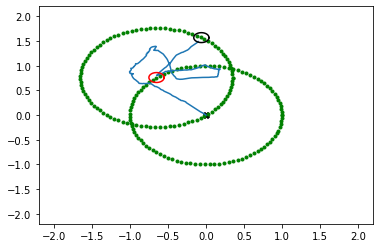

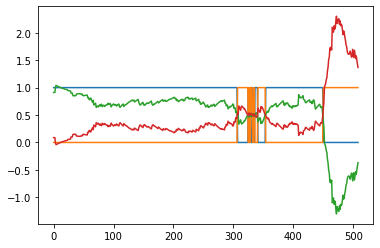

In [426]:
Rs = []
btn_dists = []
targ_dists = []

for th in range(1): # np.linspace(0,1,30,endpoint=False):
    
    btn_theta = random.random()*2*np.pi
    targ_theta = random.random()*2*np.pi
    
    btn_dist = 1.0
    targ_dist = 1.0
    
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))
    
    res = make_test(btn_test, targ_test, show_plot=True, use_HighNetwork=True)
    
    Rs.append(res['R'])
    btn_dists.append(res['min_btn_dist'])
    targ_dists.append(res['min_targ_dist'])
    
    plt.plot(res['context'])
    plt.plot(res['ACTIONS_HIGH'])
    plt.show()

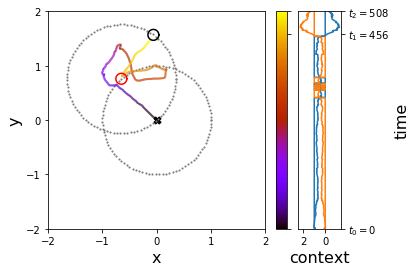

In [428]:
X = np.array(res['POSITION'])[:,0]
Y = np.array(res['POSITION'])[:,1]

dX = 1
while dX < 0.2 + max(abs(np.min(X)),abs(np.max(X))) or dX < 0.2 + max(abs(np.min(Y)),abs(np.max(Y))):
    dX += 0.5

fig, ax = plt.subplots()

path = mpath.Path(np.column_stack([X, Y]))
verts = path.interpolated(steps=3).vertices
x, y = verts[:, 0], verts[:, 1]
z = np.linspace(0, 1, len(x))
colorline(x, y, z, cmap=plt.get_cmap('gnuplot'), linewidth=2)
ax.set_xlim([-dX,dX])
ax.set_ylim([-dX,dX])
ax.scatter(0,0,marker='X',color='black',s=50)
ax.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
ax.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
ax.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='grey', marker='.', s=5)
ax.scatter([btn_test[0]+1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[btn_test[1]+1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='grey', marker='.', s=5)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

t1 = res['t_reach_btn']/(res['t_reach_targ'])
img = plt.imshow(np.array([[0,1]]), cmap=plt.get_cmap('gnuplot'))
img.set_visible(False)
axins = inset_axes(ax, width="5%", height="100%", bbox_to_anchor=(1.05, 0.00, 1, 1), bbox_transform=ax.transAxes, loc=3, borderpad=0)
cbar = fig.colorbar(img, cax=axins, ticks=[0,t1,1])
cbar.ax.set_yticklabels(['','','']) # [r'$t_0=0$', r'$t_1=%d$' % res['t_reach_btn'], r'$t_2=%d$' % res['t_reach_targ']])
cbar.set_label('time', rotation=90, fontsize=16, labelpad=100)

axins2 = inset_axes(ax, width="20%", height="100%", bbox_to_anchor=(1.15, 0.00, 1, 1), bbox_transform=ax.transAxes, loc=3, borderpad=0)
#cbar = fig.colorbar(img, cax=axins, ticks=[0,t1,1])
#cbar.ax.set_yticklabels([r'$t_0=0$', r'$t_1=%d$' % res['t_reach_btn'], r'$t_2=%d$' % res['t_reach_targ']])
#cbar.set_label('time', rotation=270, fontsize=16, labelpad=18)
axins2.plot()
axins2.plot(res['context'],[_/res['t_reach_targ'] for _ in range(res['t_reach_targ']+1)])
for n in range(2):
    axins2.plot(np.array(res['ACTIONS_HIGH']).T[n],[_/(res['t_reach_targ']+1) for _ in range(res['t_reach_targ']+1)], color='C'+str(n))
a,b = axins2.get_xlim()
axins2.set_xlim([b,a])
axins2.set_ylim([0,1])
axins2.set_yticks([0,t1,1])
axins2.set_yticklabels([r'$t_0=0$', r'$t_1=%d$' % res['t_reach_btn'], r'$t_2=%d$' % res['t_reach_targ']])
axins2.yaxis.tick_right()
axins2.set_xlabel('context', fontsize=16)

plt.show()

In [343]:
len(res['POSITION'])

359

1) aumentare sigma_targ della rete alta (per aumentare i burst)
2) provare a fare un po più di training
3) verificare l'allineamento temporale in fase di training (magari nel training l'agente raggiunge il bordo e non il centro del bottone)

In [422]:
Rs = []
btn_dists = []
targ_dists = []

for btn_theta in np.linspace(0,2*np.pi,30,endpoint=False):
    
    targ_theta = random.random()*2*np.pi
    
    btn_dist = 1.0
    targ_dist = 1.0
    
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))
    
    res = make_test(btn_test, targ_test, show_plot=False, use_HighNetwork=True)
    
    Rs.append(res['R'])
    btn_dists.append(res['min_btn_dist'])
    targ_dists.append(res['min_targ_dist'])

btn_theta = 0.000
R = 0.000
min_btn_dist = 0.130
t_reach = [1500,1500]
btn_theta = 0.209
R = 10.100
min_btn_dist = 0.025
t_reach = [578,637]
btn_theta = 0.419
R = 10.276
min_btn_dist = 0.059
t_reach = [1128,1200]
btn_theta = 0.628
R = 9.626
min_btn_dist = 0.037
t_reach = [64,1500]
btn_theta = 0.838
R = 10.441
min_btn_dist = 0.093
t_reach = [96,216]
btn_theta = 1.047
R = 5.402
min_btn_dist = 0.066
t_reach = [1404,1500]
btn_theta = 1.257
R = 10.309
min_btn_dist = 0.004
t_reach = [314,463]
btn_theta = 1.466
R = 0.000
min_btn_dist = 0.132
t_reach = [1500,1500]
btn_theta = 1.676
R = 11.573
min_btn_dist = 0.065
t_reach = [101,178]
btn_theta = 1.885
R = 12.071
min_btn_dist = 0.053
t_reach = [1058,1205]
btn_theta = 2.094
R = 0.000
min_btn_dist = 0.100
t_reach = [1500,1500]
btn_theta = 2.304
R = 10.375
min_btn_dist = 0.069
t_reach = [935,1210]
btn_theta = 2.513
R = 0.000
min_btn_dist = 0.202
t_reach = [1500,1500]
btn_theta = 2.723
R = 10.594
min_btn_dist = 0.019
t_reach = [122,301]
btn_theta = 

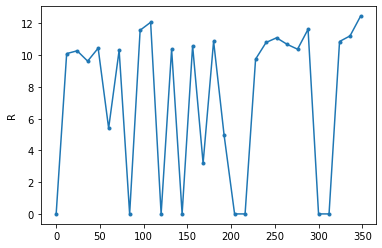

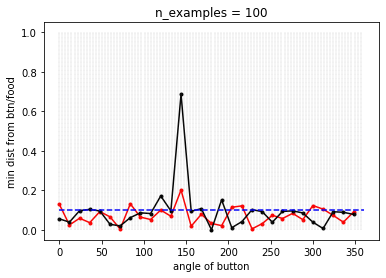

In [424]:
th = np.linspace(0,360,30,endpoint=False)

plt.plot(th, Rs, marker='.')
plt.ylabel('R')
plt.show()

plt.title('n_examples = %d' % n_examples)
plt.plot(th, btn_dists, marker='.', color='red')
plt.plot(th, targ_dists, marker='.', color='black')
plt.plot([0,360], [0.1,0.1], ls='--', color='blue')
for th in train_thetas:
    plt.plot([th/2/np.pi*360,th/2/np.pi*360],[0,1],ls='--',color='gray',lw=0.25)
plt.xlabel('angle of button')
plt.ylabel('min dist from btn/food')
plt.show()

In [290]:
train_thetas

[2.52299293616753,
 0.969591500857559,
 1.140708900302102,
 3.0029161643653492,
 0.2310405821856491,
 0.6681815597950457,
 1.6523718323579166,
 0.6707626586301276,
 5.261259910639258,
 4.575919047460333,
 3.91796055546683,
 6.213717040553316,
 2.850080279385435,
 6.160270525171928,
 5.325837119068753,
 5.354466268829198,
 1.4029414667225832,
 5.5067320269454,
 3.988463532280372,
 5.016327747526899]

In [27]:
np.array(POSITION)[0,:]
print( np.sqrt( np.sum((np.array(POSITION)[50,:] - btn_test)**2) ) )

NameError: name 'POSITION' is not defined

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(POSITION[0,:])
plt.plot(POSITION[1,:])
plt.subplot(212)

plt.plot(context)

In [74]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 0
R = 0
R = 0
R = 4.626371807823789
R = 0
R = 10.341577828430156
R = 10.271286194102471
R = 0
R = 5.636280050593238
R = 0
R = 0
R = 0
R = 0
R = 0
R = 4.796671672409694
R = 0
R = 10.042919213210986
R = 0
R = 0


Text(0.5, 0, 'Reward')

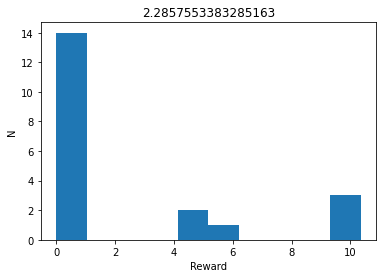

In [75]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")